# <center> **NLP analysis of Movie comments dataset**


## Table of Contents

1. **[Functions](#1)**
2. **[General EDA](#2)**
	* [Analyzing Text Statistics](#sub-heading1)
3. **[Text Data Preprocessing](#3)**
	* [Cleaning](#sub-heading2)
	* [Tokenization](#sub-heading3)
	* [Normalisation (comparison of stemming and lemmatization)](#sub-heading4)
4. **[Baseline model](#4)**
	* [Data Loader + TFIDF](#sub-heading)
	* [Split](#sub-heading)
	* [Model](#sub-heading)
5. **[RNN models](#5)**
	* [Pretrained embedding (word2vec)](#sub-heading)
     + [Dataset loader](#sub-sub-heading-1) 
     + [Split](#sub-sub-heading-2)
     + [RNN](#sub-sub-heading-2)
     + [LSTM](#sub-sub-heading-2)
     + [Bidirectional LSTM](#sub-sub-heading-2)
     + [GRU](#sub-sub-heading-2)
	* [Glove Embedding](#sub-heading)
     + [Dataset loader](#sub-sub-heading-1) 
     + [Split](#sub-sub-heading-2)
     + [RNN](#sub-sub-heading-2)
     + [LSTM](#sub-sub-heading-2)
     + [Bidirectional LSTM](#sub-sub-heading-2)
	* [Make own vocab by train word2vec model](#sub-heading)
     + [Dataset loader](#sub-sub-heading-1) 
     + [Split](#sub-sub-heading-2)
     + [LSTM](#sub-sub-heading-2)
6. **[BERT Model](#6)**
7. **[General conclusion](#7)**




In [1]:
!pip install unidecode
!pip install emoji
!pip install word2number
!pip install contractions
!pip3 install spacy
!python3 -m spacy download en_core_web_sm
!python3 -m nltk.downloader stopwords
!pip install pyspellchecker
!pip install iplot

     |████████████████████████████████| 235 kB 5.4 MB/s 
     |████████████████████████████████| 170 kB 5.3 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=a2173a6446cbbafe74db20846b97ad4cdd471d9d2689debe21d31bf15e8d5ab0
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji
  Created wheel for word2number: filename=word2number-1.1-py3-none-any.whl size=5580 sha256=cda2ce8e4dc2c40d86b4bbfc3ebca79b861cffd893716d20bbe227188f93246a
  Stored in directory: /root/.cache/pip/wheels/4b/c3/77/a5f48aeb0d3efb7cd5ad61cbd3da30bbf9ffc9662b07c9f879
Successfully built word2number
     |████████████████████████████████| 284 kB 5.3 MB/s 
     |████████████████████████████████| 321 kB 39.6 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85450 sha256=608ddd29a8cdf9a019c9f37c8935b44b57bc1759f723cb5bf55290c41ba2d109
  Stored in director

In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn')
%matplotlib inline
#graphs in svg look clearer
%config InlineBackend.figure_format = 'svg' 
import warnings
warnings.simplefilter('ignore')

from google.colab import drive
import os
import string
import emoji

import plotly as py
import numpy as np
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import Contours, Histogram2dContour, Marker, Scatter

import unidecode
from word2number import w2n
import contractions
from bs4 import BeautifulSoup
import spacy

import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from spellchecker import SpellChecker
from wordcloud import WordCloud

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas(desc='PROGRESS>>>')

from google_drive_downloader import GoogleDriveDownloader as gdd
from IPython.core.display import display, HTML

from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, StratifiedKFold, KFold, cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import label_binarize, StandardScaler

from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
import gensim
import gensim.downloader as api
from gensim.models import Word2Vec

import gensim.downloader as gensim_api
from torch.nn.utils.rnn import pad_sequence

from functools import partial
import torch   
# from torchtext import data    
import torch.nn as nn
from torch.utils.data import TensorDataset, ConcatDataset, DataLoader, random_split, Dataset
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
import torch.optim as optim

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/My Drive/DA/HW6/LargeMovieReviewDataset.csv', sep=',')

# **Functions**

**Top words**

In [ ]:
def draw_top_words(data, top_size, title):
  counting_table = pd.DataFrame(count_words(data, top_size))
  counting_table.drop([0],inplace=True)
  counting_table.columns = ['word','counting']

  plt.figure(figsize=(17,10))
  ax= sns.barplot(data=counting_table,x='word',y='counting',facecolor=(1, 1, 1, 0),edgecolor='black')
  if title == 'Top' or title == 'top':
    ax.set_title(f'Top {top_size} words'.title(),fontsize=20)
  else:
    ax.set_title(f'{title} words: Top {top_size}'.title(),fontsize=20)

  ax.set_ylabel('Word counting',fontsize=15)
  ax.set_xlabel(f'Top {top_size} words',fontsize=15);
  plt.xticks(rotation=45)
  plt.show()

**Word clouds**

In [ ]:
def draw_word_clouds(pos, neg):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
  wordcloud1 = WordCloud( background_color='white',
                          width=600,
                          height=400).generate(" ".join(neg['review']))
  ax1.imshow(wordcloud1)
  ax1.axis('off')
  ax1.set_title('Negative comment',fontsize=40);

  wordcloud2 = WordCloud( background_color='white',
                          width=600,
                          height=400).generate(" ".join(pos['review']))
  ax2.imshow(wordcloud2)
  ax2.axis('off')
  ax2.set_title('Positive comment',fontsize=40);

**Activate Plotly**

In [ ]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

**Removal of html tags**

In [ ]:
def strip_html_tags(text):
    """remove html tags from text"""
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text

**Removal of whitespaces**

In [ ]:
def remove_whitespace(text):
    """remove extra whitespaces from text"""
    text = text.strip()
    return " ".join(text.split())

**Removal of accented characters**

In [ ]:
def remove_accented_chars(text):
    """remove accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    return text

**Removal of shortened words**

In [ ]:
def expand_contractions(text):
    """expand shortened words, e.g. don't to do not"""
    text = contractions.fix(text)
    return text

**Removal of urls**

In [ ]:
def find_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.findall(text)

In [ ]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

**Removal of Frequent words**

In [ ]:
def count_words(text, top=10):
    cnt = Counter()
    for text in text.values:
        for word in text.split():
            cnt[word] += 1
            
    return cnt.most_common(top)

In [ ]:
FREQWORDS = set([w for (w, wc) in count_words(df['review'], 10)])
FREQWORDS

{'I', 'a', 'and', 'in', 'is', 'of', 'that', 'the', 'this', 'to'}

In [ ]:
n_rare_words = 10
RAREWORDS = set([w for (w, wc) in count_words(df['review'][:-n_rare_words-1:-1])])
RAREWORDS

{'/><br', 'a', 'and', 'his', 'in', 'is', 'of', 'the', 'this', 'to'}

In [ ]:
def remove_freqwords(text):
    """remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

**Removal of Rare words**

In [ ]:
def remove_rarewords(text):
    """remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

**Removal of stopwords**


In [ ]:
STOPWORDS = set(stopwords.words('english'))

def remove_stopwords(text):
    """remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

**Convert chat words**

In [ ]:
chat_words_str = """
AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The A..
PRT=Party
PRW=Parents Are Watching
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My A.. Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The F...
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait...
7K=Sick:-D Laugher
"""

In [ ]:
def chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

**Convertion of emoticons**

In [ ]:
EMOTICONS = {
    u":‑\)":"Happy face or smiley",
    u":\)":"Happy face or smiley",
    u":-\]":"Happy face or smiley",
    u":\]":"Happy face or smiley",
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u"8-\)":"Happy face smiley",
    u":o\)":"Happy face smiley",
    u":-\}":"Happy face smiley",
    u":\}":"Happy face smiley",
    u":-\)":"Happy face smiley",
    u":c\)":"Happy face smiley",
    u":\^\)":"Happy face smiley",
    u"=\]":"Happy face smiley",
    u"=\)":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B\^D":"Laughing, big grin or laugh with glasses",
    u":-\)\)":"Very happy",
    u":‑\(":"Frown, sad, andry or pouting",
    u":-\(":"Frown, sad, andry or pouting",
    u":\(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑\[":"Frown, sad, andry or pouting",
    u":\[":"Frown, sad, andry or pouting",
    u":-\|\|":"Frown, sad, andry or pouting",
    u">:\[":"Frown, sad, andry or pouting",
    u":\{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:\(":"Frown, sad, andry or pouting",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"Tears of happiness",
    u":'\)":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"Wink or smirk",
    u";\)":"Wink or smirk",
    u"\*-\)":"Wink or smirk",
    u"\*\)":"Wink or smirk",
    u";‑\]":"Wink or smirk",
    u";\]":"Wink or smirk",
    u";\^\)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed or blushing",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑\)":"Angel, saint or innocent",
    u"O:\)":"Angel, saint or innocent",
    u"0:‑3":"Angel, saint or innocent",
    u"0:3":"Angel, saint or innocent",
    u"0:‑\)":"Angel, saint or innocent",
    u"0:\)":"Angel, saint or innocent",
    u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"0;\^\)":"Angel, saint or innocent",
    u">:‑\)":"Evil or devilish",
    u">:\)":"Evil or devilish",
    u"\}:‑\)":"Evil or devilish",
    u"\}:\)":"Evil or devilish",
    u"3:‑\)":"Evil or devilish",
    u"3:\)":"Evil or devilish",
    u">;\)":"Evil or devilish",
    u"\|;‑\)":"Cool",
    u"\|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑\)":"Party all night",
    u"%‑\)":"Drunk or confused",
    u"%\)":"Drunk or confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑\|":"Dump",
    u"\(>_<\)":"Troubled",
    u"\(>_<\)>":"Troubled",
    u"\(';'\)":"Baby",
    u"\(\^\^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(\^_\^;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"\('_'\)":"Sad or Crying",
    u"\(/_;\)":"Sad or Crying",
    u"\(T_T\) \(;_;\)":"Sad or Crying",
    u"\(;_;":"Sad of Crying",
    u"\(;_:\)":"Sad or Crying",
    u"\(;O;\)":"Sad or Crying",
    u"\(:_;\)":"Sad or Crying",
    u"\(ToT\)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u";;":"Sad or Crying",
    u"Q\.Q":"Sad or Crying",
    u"T\.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling with hand covering mouth",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Normal Laugh",
    u"<\^!\^>":"Normal Laugh",
    u"\^/\^":"Normal Laugh",
    u"\（\*\^_\^\*）" :"Normal Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
    u"\(^\^\)":"Normal Laugh",
    u"\(\^\.\^\)":"Normal Laugh",
    u"\(\^_\^\.\)":"Normal Laugh",
    u"\(\^_\^\)":"Normal Laugh",
    u"\(\^\^\)":"Normal Laugh",
    u"\(\^J\^\)":"Normal Laugh",
    u"\(\*\^\.\^\*\)":"Normal Laugh",
    u"\(\^—\^\）":"Normal Laugh",
    u"\(#\^\.\^#\)":"Normal Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Laughing,Cheerful",
    u"\(\^_\^\)v":"Laughing,Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed or Deflated"
}

In [ ]:
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    return text

**Removal of Punctuations**

In [ ]:
PUNCT_TO_REMOVE = string.punctuation

def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

**Removal of numbers**

In [ ]:
def remove_numbers(input):
  input_str = re.sub(r'\d+', "", input)
  return input_str

**Find emoji**

In [ ]:
def extract_emojis(s):
  return ''.join(c for c in s if c in emoji.UNICODE_EMOJI['en'])

**Stemming**

In [ ]:
stemmer = PorterStemmer()

def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text])

In [ ]:
def remove_rare_words(tokens, common_tokens, max_len):
    return [token if token in common_tokens else '<UNK>' for token in tokens][-max_len:]

**Splitting**

In [ ]:
def split_train_valid_test(corpus, valid_ratio=0.1, test_ratio=0.1):
    """Split dataset into train, validation, and test."""
    test_length = int(len(corpus) * test_ratio)
    valid_length = int(len(corpus) * valid_ratio)
    train_length = len(corpus) - valid_length - test_length
    return random_split(
        corpus, lengths=[train_length, valid_length, test_length],
    )

**Draw curves**

In [ ]:
def draw_visualization(iteration_list, loss_list, accuracy_list):
    # visualization loss 
    plt.plot(iteration_list,loss_list)
    plt.xlabel("Number of iteration")
    plt.ylabel("Loss")
    plt.title("Loss vs Number of iteration")
    plt.show()

    # visualization accuracy 
    plt.plot(iteration_list,accuracy_list,color = "red")
    plt.xlabel("Number of iteration")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Number of iteration")
    plt.show()

**Word importance**

In [ ]:
def get_word_importance(model,tfidf, top=15):

    important_tokens = pd.DataFrame(
        data=model.coef_[0],
        index=tfidf.get_feature_names(),
        columns=['Coefs']
    )

    important_tokens_pos = important_tokens.sort_values(by='Coefs', ascending=False)[:top]
    important_tokens_neg = important_tokens.sort_values(by='Coefs', ascending=False)[-top:]

    word_imp = important_tokens_pos.copy(deep=True)
    word_imp = word_imp.append(important_tokens_neg)

    plt.figure(figsize=(15,10))
    sns.barplot(x=word_imp.index, y='Coefs', data=word_imp)
    plt.title('Word importance')
    plt.xlabel('POS             vs.               NEG')
    plt.ylabel('word weight')
    plt.xticks(rotation=55)
    plt.show()

**Word2vec**

In [ ]:
def conv_word2vec(doc):
    """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
    doc = [word for word in doc if word in nlp.wv.vocab]
    return nlp[doc]

**Save or load model checkpoint**

In [ ]:
def save_checkpoint(model, optimizer, learning_rate, iteration, filepath):
    print("Saving model and optimizer state at iteration {} to {}".format(
        iteration, filepath))

    model_state_dict = model.state_dict().copy()

    torch.save({'iteration': iteration,
                'state_dict': model_state_dict,
                'optimizer': optimizer.state_dict(),
                'learning_rate': learning_rate}, filepath)

In [ ]:
def load_checkpoint(checkpoint_path, model, optimizer):
    assert os.path.isfile(checkpoint_path)
    print("Loading checkpoint '{}'".format(checkpoint_path))
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')

    model.load_state_dict(checkpoint_dict['state_dict'])
    optimizer.load_state_dict(checkpoint_dict['optimizer'])
    learning_rate = checkpoint_dict['learning_rate']
    iteration = checkpoint_dict['iteration']
    print("Loaded checkpoint '{}' from iteration {}" .format(
        checkpoint_path, iteration))
    return model, optimizer, learning_rate, iteration

**Classification metrics**

In [ ]:
!ls

%cd /content/drive/My Drive/DA/HW5/

from plot_cm import plot_confusion_matrix

drive  sample_data
/content/drive/My Drive/DA/HW5


In [ ]:
from plot_roc import plot_roc

In [ ]:
def calc_metrics(test_label, preds):
    classes_names = ['negative', 'positive']
    num_classes = 2

    plot_confusion_matrix(cm=metrics.confusion_matrix(test_label, preds),
                          target_names=classes_names,
                          normalize=False)
    
    print("Accuracy:",
          round(metrics.accuracy_score(test_label, preds), 5),
        '\nBalanced accuracy:',
        round(metrics.balanced_accuracy_score(test_label, preds), 5), 
        '\nMulticlass f1-score:',
        '\n    micro:', round(metrics.f1_score(test_label, preds, average='micro'), 5),
        '\n    macro:', round(metrics.f1_score(test_label, preds, average='macro'), 5),
        '\n    weighted:', round(metrics.f1_score(test_label, preds, average='weighted'), 5))

    print('\n\nClassification report:\n')
    print(metrics.classification_report(test_label, preds, digits=5))

In [ ]:
classes_names = ['negative', 'positive']
num_classes = 2

**ROC AUC metric**

In [ ]:
def count_roc_auc(model, testData, test_label, num_classes, classes_names):
    preds_prob = model.predict_proba(testData)[:,1]

    classes_names = ['negative', 'positive']
    num_classes = 2
    print('ROC AUC:',
         '\n    macro:', round(metrics.roc_auc_score(test_label, preds_prob, multi_class='ovr', average='macro'), 5),
         '\n    weighted:', round(metrics.roc_auc_score(test_label, preds_prob, multi_class='ovr', average='weighted'), 5))

    plot_roc(test_label, preds_prob, target_names=classes_names)

In [ ]:
def count_rocauc_classif(model, testData, test_label):
    preds_prob = model.decision_function(testData)

    classes_names = ['negative', 'positive']
    num_classes = 2
    print('ROC AUC:',
          '\n    macro:', round(metrics.roc_auc_score(test_label, preds_prob, multi_class='ovr', average='macro'), 5),
          '\n    weighted:', round(metrics.roc_auc_score(test_label, preds_prob, multi_class='ovr', average='weighted'), 5))

    plot_roc(test_label, preds_prob, target_names=classes_names)

**ROC AUC cross validation**

In [ ]:
def calc_rocauc_cross_val(model, testData, test_label):
  skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)

  scores = cross_val_score(model, testData, test_label, cv=skf, scoring='roc_auc')
  print('ROC AUC mean score after cross-val:   ', np.mean(scores))

  pd.Series(scores).plot()
  plt.ylabel('roc_auc')
  plt.xlabel('iteration')
  plt.title('Model')
  plt.show()

# **General EDA**

**Chech missing data**

In [ ]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

**Let's look at an example of each sentiment:**  
 positive, negative

In [ ]:
# positive_text
print("Positive example :")
df[df['sentiment']=='positive']['review'].values[0]

Positive example :


"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [ ]:
#negative_text
print("Negative example :")
df[df['sentiment']=='negative']['review'].values[0]

Negative example :


"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

**Distribution of the Sentiment Column**

In [ ]:
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

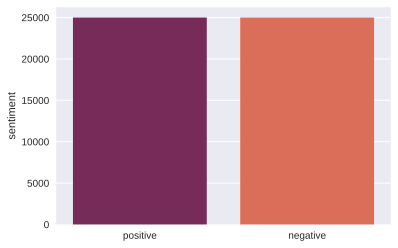

In [ ]:
sns.barplot(df['sentiment'].value_counts().index,df['sentiment'].value_counts(),palette='rocket')
plt.show()

**Conclusion**  

The graph shows that the number of positive and negative comments is equal.

## **Analyzing Text Statistics** 

We can now do some statistical analysis to explore the fundamental characteristics of the text data. Some of the analysis which can be useful are:

To perform these analysis, let us create two new features: 

- one which calculates the length of the text, and second which calculates the word count.

In [ ]:
new_df = df.copy(deep=True)

Looking at text length distribution:

In [ ]:
new_df['text_len'] = new_df['review'].astype(str).apply(len)
new_df['text_word_count'] = new_df['review'].apply(lambda x: len(str(x).split()))
new_df.head(1)

review  \
0  One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.   

  sentiment  text_len  text_word_count  
0  positive      1761              307

In [ ]:
pos = new_df[new_df['sentiment']=='positive']
neg = new_df[new_df['sentiment']=='negative']

In [ ]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [ ]:
configure_plotly_browser_state()

init_notebook_mode(connected=False)

pos['text_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    color='red',
    yTitle='count',
    title='Positive Text Length Distribution')

neg['text_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    color='green',
    yTitle='count',
    title='Negative Text Length Distribution')

**Conclusion**

* The histogram shows that the length of not cleaned text ranges from around 1 to 12k+ characters for positive polarity and from 2 to 9000 characters for negative polarity. 

Let's see a more consolidated comparison of the relationship of text lengths with sentiment of the text.

In [ ]:
import plotly.graph_objects as go

In [ ]:
configure_plotly_browser_state()

init_notebook_mode(connected=False)

trace0 = go.Box(
    y=pos['text_len'],
    name = 'Positive Text',
    marker = dict(
        color = 'red',
    )
)

trace1 = go.Box(
    y=neg['text_len'],
    name = 'Negative Text',
    marker = dict(
        color = 'green',
    )
)

data = [trace0, trace1]
layout = go.Layout(
    title = "Length of the text"
)

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "Length of the text of different polarities")

**Conclusion**

* The biggest part of comments appear to have more or less same length. Hence, length of the text isn't a powerful indicator of the polarity.  
* However, there aresome outliers in positive comments.

**Word clouds**

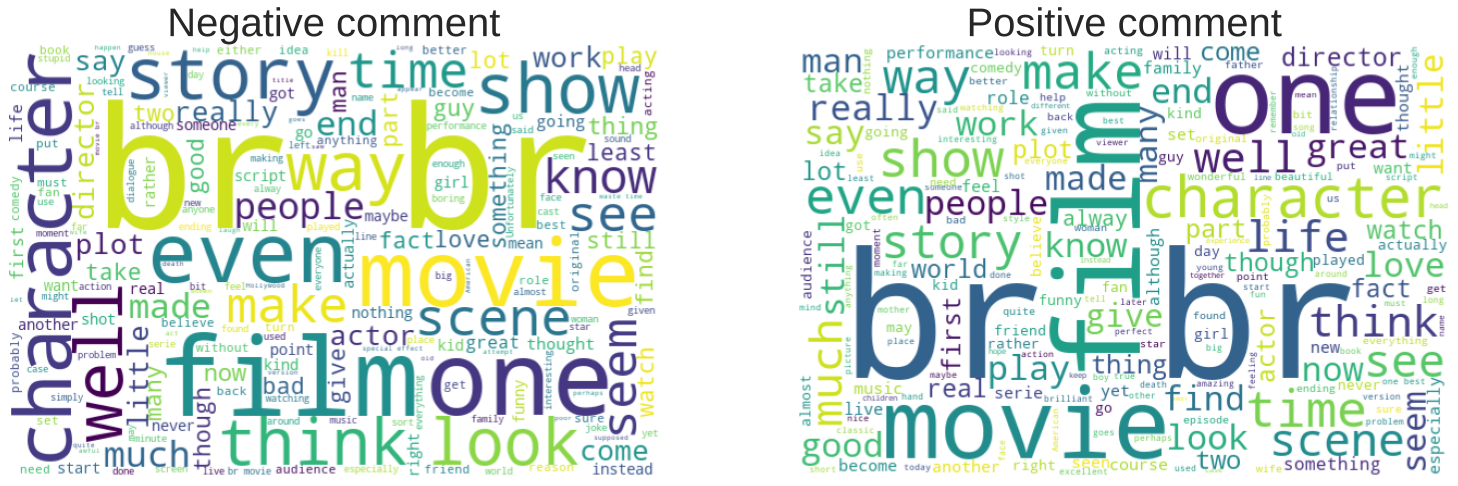

In [ ]:
draw_word_clouds(pos, neg)

**Conclusion**

* It is obvious that the text has not been processed and popular words do not yet carry a special semantic load, it is worth looking at the word clouds after processing, they should be more informative.
* br is the most frequent one. But br is a sort of HTML tag, Thus it should be removed.
* Movie or film is the theme which all reviews share. Thus I suppose idf(inverse document frequency) should be close to zero.

# **Text Data Preprocessing**

Save the original data:

In [ ]:
data = df.copy(deep=True)

Look at dataset:

In [ ]:
data.shape

(50000, 2)

In [ ]:
data.head()

review  \
0  One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

* We can see HTML tags, numbers, abbreviations, and much more, from which should be cleared from the text.

**Check missing values**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


* No NaNs in data.

In [ ]:
data['review']= data['review'].astype("string")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  string
 1   sentiment  50000 non-null  object
dtypes: object(1), string(1)
memory usage: 781.4+ KB


## **Cleaning**

**Lower Casing**  
Lower casing is a common text preprocessing technique. The idea is to convert the input text into same casing format so that 'text', 'Text' and 'TEXT' are treated the same way.  

This is more helpful for text featurization techniques like frequency, tfidf as it helps to combine the same words together thereby reducing the duplication and get correct counts / tfidf values.  

**Some other parts like:** *html removal, extra whitespaces removal are also important.*

These may not be helpful when we do tasks like Part of Speech tagging (where proper casing gives some information about Nouns and so on) and Sentiment Analysis (where upper casing refers to anger and so on)  

In [ ]:
def text_preprocessing():
    
    #remove html tags
    data['review'] = data['review'].apply(strip_html_tags)
    print('>>> REMOVE HTML TAGS <<<')
    print(data.head(1), '\n')

    #remove extra whitespaces
    data['review'] = data['review'].apply(remove_whitespace)
    print('>>> REMOVE EXTRA WHITESPACES <<<')
    print(data.head(1), '\n')

    #remove accented characters
    data['review'] =  data['review'].apply(remove_accented_chars)
    print('>>> REMOVE ACCENTED CHARS <<<')
    print(data.head(1), '\n')

    #expand contractions
    data['review'] =  data['review'].apply(expand_contractions)
    print('>>> EXPAND CONTRACTIONS <<<')
    print(data.head(1), '\n')

    #convert all characters to lowercase
    data['review'] =  data['review'].str.lower()
    print('>>> LOWERCASE <<<')
    print(data.head(1), '\n')


**Run 1st step of text preprocessing**

In [ ]:
text_preprocessing()

>>> REMOVE HTML TAGS <<<
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

**Removal of URLs**  
Next preprocessing step is to remove any URLs present in the data. Probably we might need to remove them for our further analysis.


1st of all, I check whether there are any URLs in dataset:

In [ ]:
for i in data['review']:
    url = find_urls(i)
    if url == []:
      continue
    else:
      print(url)

['www.cei.org.', 'www.cei.org/pdf/5539.pdf']
['http://www.invocus.net)']
['http://blog.myspace.com/locoformovies']
['www.softfordigging.com']
['www.petitiononline.com/19784444/petition.html']
['http://www.comingsoon.net/films.php?id=36310']
['http://tinyurl.com/znyyq']
['www.residenthazard.com)']
['http://www.zonadvd.com']
['http://imdb.com/name/nm0834754/bio']
['www.nixflix.com']
['http://rateyourmusic.com/collection/fedor8/1']
['www.abc.net.au/chaser.']
['www.lovetrapmovie.com']
['http://imdb.com/title/tt0449040/.']
['http://www.thepetitionsite.com']
['http://www.petitiononline.com/gh1215/petition.html']
['http://www.johntopping.com/harvey%20perr/war%20widow/war_widow.html']
['www.mediasickness.com']
['http://www.imdb.com/title/tt0073891/']
['www.residenthazard.com)']
['http://eattheblinds.blogspot.com/']
['http://www.imdb.com/title/tt0363163/']
['www.nixflix.com']
['www.poffysmoviemania.com)']
['http://eattheblinds.blogspot.com/']
['http://www.gutenberg.org/ebooks/18137']
['http://f

In [ ]:
data['review'] = data['review'].apply(lambda text: remove_urls(text))
data.head(1)

**Removal of Emoticons**  

There is a minor difference between emojis and emoticons.
Emoticon is built from keyboard characters that when put together in a certain way represent a facial expression, an emoji is an actual image.

:-) is an emoticon

😀 is an emoji

**!** The removal of emojis / emoticons are not always preferred and decision should be made based on the use case at hand.

* For this task, I will only remove the") " sign, since it is not always a smiley here, and I will translate the remaining emoticons into text to help the model understand the emotional coloring.

In [ ]:
data['review'] = data['review'].apply(lambda text: text.replace(')', ''))
data.head(1)

review  \
0  one of the other reviewers has mentioned that after watching just 1 oz episode you will be hooked. they are right, as this is exactly what happened with me. the first thing that struck me about oz was its brutality and unflinching scenes of violence, which set in right from the word go. trust me, this is not a show for the faint hearted or timid. this show pulls no punches with regards to drugs, sex or violence. its is hardcore, in the classic use of the word. it is called oz as that is the nickname given to the oswald maximum security state penitentary. it focuses mainly on emerald city, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. them city is home to many..aryans, muslims, gangstas, latinos, christians, italians, irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away. i would say the main appeal of the show is due to the fact that it goes where other shows would not dare. forget pretty pictures painted for mainstream audiences, forget charm, forget romance...oz does not mess around. the first episode i ever saw struck me as so nasty it was surreal, i could not say i was ready for it, but as i watched more, i developed a taste for oz, and got accustomed to the high levels of graphic violence. not just violence, but injustice (crooked guards who will be sold out for a nickel, inmates who will kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience watching oz, you may become comfortable with what is uncomfortable viewing....that is if you can get in touch with your darker side.   

  sentiment  
0  positive

In [ ]:
def find_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    return emoticon_pattern.findall(text)

for i in data['review']:
    em = find_emoticons(i)
    if em == []:
      continue
    else:
      print(em)

['0:3']
[':3']
[':3']
['d:']
['d:']
['d:']
['d:']
['d:']
[':3', ':3', ':3', ':3', ':3', ':3']
[':-(']
[':3', ':3']
['d:', 'd:']
['d:']
['d:']
['d:']
[':b']
[':3']
[':/']
['d:']
[':3']
['d:']
['d:']
[':/']
[':']
[':']
['d:']
['d:']
['d:']
['d:']
['d:']
[':[', ':[', ':[', ':[', ':[']
['d:']
[':']
['d:']
['d:']
['d:']
['d:']
['d:']
['d:']
['d:', 'd:']
['d:']
['d:']
['d:']
[':(']
['d:']
[':/', '=3']
['d:']
['d:']
['d:']
['d:']
['=]']
['d:']
['d:']
[':/']
[':o']
[':']
[':']
[':3']
[':(']
['d:']
['d:']
[':o']
['d:']
['d:', 'd:']
[':3', ':3']
['d:', 'd:']
['d:']
[':c']
['d:']
['d:']
[':3']
['d:']
['d:']
['d:']
[':/']
['d:']
['d:', 'd:', 'd:', 'd:', 'd:', 'd:', 'd:', 'd:', 'd:', 'd:', 'd:', 'd:', 'd:']
['d:']
[':/']
['d:']
[':o']
['d:']
['d:']
['d:']
['d:']
[':3']
['d:']
['d:']
['d:']
[':/']
['d:']
['d:']
['^_^']
['d:']
[':']
['d:']
['d:']
['d:']
['d:']
[':-(']
[':-(']
['d:']
[':o']
['d:']
['d:']
['d:', ':c']
[':b']
['d:']
[':o']
['d:']
['d:']
['d:']
[':(']
['d:']
['d:']
[':/']
['d:']
[':3']
[

**Conversion of Emoticon to Words**  

 In case of use cases like sentiment analysis, the emoticons give some valuable information and so removing them might not be a good solution.

In [ ]:
data['review'] = data['review'].apply(lambda text: convert_emoticons(text))
data.head(1)

review  \
0  one of the other reviewers has mentioned that after watching just 1 oz episode you will be hooked. they are right, as this is exactly what happened with me. the first thing that struck me about oz was its brutality and unflinching scenes of violence, which set in right from the word go. trust me, this is not a show for the faint hearted or timid. this show pulls no punches with regards to drugs, sex or violence. its is hardcore, in the classic use of the word. it is called oz as that is the nickname given to the oswald maximum security state penitentary. it focuses mainly on emerald city, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. them city is home to many..aryans, muslims, gangstas, latinos, christians, italians, irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away. i would say the main appeal of the show is due to the fact that it goes where other shows would not dare. forget pretty pictures painted for mainstream audiences, forget charm, forget romance...oz does not mess around. the first episode i ever saw struck me as so nasty it was surreal, i could not say i was ready for it, but as i watched more, i developed a taste for oz, and got accustomed to the high levels of graphic violence. not just violence, but injustice (crooked guards who will be sold out for a nickel, inmates who will kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience watching oz, you may become comfortable with what is uncomfortable viewing....that is if you can get in touch with your darker side.   

  sentiment  
0  positive

**Removal of Punctuations**  
One another common text preprocessing technique is to remove the punctuations from the text data. This is again a text standardization process that will help to treat 'yes' and 'yes!' in the same way.

In [ ]:
data['review'] =  data['review'].apply(lambda text: remove_punctuation(text))
data.head(1)

review  \
0  one of the other reviewers has mentioned that after watching just 1 oz episode you will be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda them city is home to manyaryans muslims gangstas latinos christians italians irish and moreso scuffles death stares dodgy dealings and shady agreements are never far away i would say the main appeal of the show is due to the fact that it goes where other shows would not dare forget pretty pictures painted for mainstream audiences forget charm forget romanceoz does not mess around the first episode i ever saw struck me as so nasty it was surreal i could not say i was ready for it but as i watched more i developed a taste for oz and got accustomed to the high levels of graphic violence not just violence but injustice crooked guards who will be sold out for a nickel inmates who will kill on order and get away with it well mannered middle class inmates being turned into prison bitches due to their lack of street skills or prison experience watching oz you may become comfortable with what is uncomfortable viewingthat is if you can get in touch with your darker side   

  sentiment  
0  positive

**Removal of numbers**

* Here I delete only all the numbers that look like numbers, I will leave the written numbers for later.

In [ ]:
data['review'] =  data['review'].apply(lambda text: remove_numbers(text))
data.head(1)

review  \
0  one of the other reviewers has mentioned that after watching just  oz episode you will be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda them city is home to manyaryans muslims gangstas latinos christians italians irish and moreso scuffles death stares dodgy dealings and shady agreements are never far away i would say the main appeal of the show is due to the fact that it goes where other shows would not dare forget pretty pictures painted for mainstream audiences forget charm forget romanceoz does not mess around the first episode i ever saw struck me as so nasty it was surreal i could not say i was ready for it but as i watched more i developed a taste for oz and got accustomed to the high levels of graphic violence not just violence but injustice crooked guards who will be sold out for a nickel inmates who will kill on order and get away with it well mannered middle class inmates being turned into prison bitches due to their lack of street skills or prison experience watching oz you may become comfortable with what is uncomfortable viewingthat is if you can get in touch with your darker side   

  sentiment  
0  positive

**Dropping duplicates**  

Then I drop duplicates in Dataset.

In [ ]:
print('The number of duplicated data is:',sum(data.duplicated()))

The number of duplicated data is: 423


In [ ]:
data.shape

(50000, 2)

In [ ]:
data.drop_duplicates(inplace=True)

In [ ]:
data.shape

(49577, 2)

* 423 duplicates were found & deleted.

In [ ]:
data['sentiment'].value_counts()

positive    24882
negative    24695
Name: sentiment, dtype: int64

**Removal of stopwords**  
Stopwords are commonly occuring words in a language like 'the', 'a' and so on. They can be removed from the text most of the times, as they don't provide valuable information for downstream analysis.  

These stopword lists are already compiled for different languages and we can safely use them. For example, the stopword list for english language from the nltk package can be seen below.

In [ ]:
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [ ]:
data['review'] = data['review'].apply(lambda text: remove_stopwords(text))
data.head(1)

review  \
0  one reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows would dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz mess around first episode ever saw struck nasty surreal could say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches due lack street skills prison experience watching oz may become comfortable uncomfortable viewingthat get touch darker side   

  sentiment  
0  positive

**Check whether there are emojis in data:**

In [ ]:
for i in data['review']:
  em = extract_emojis(i)
  if em == '':
    continue
  else:
    print(em)

* It is obvious that there are no emojis in the dataset.

**Slang Words Conversion**  

This is an important text preprocessing step if we are dealing with "chat" data. People do use a lot of abbreviated words in chat and so it might be helpful to expand those words for our analysis purposes.

In [ ]:
chat_words_map_dict = {}
chat_words_list = []
for line in chat_words_str.split("\n"):
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1]
        chat_words_list.append(cw)
        chat_words_map_dict[cw] = cw_expanded
chat_words_list = set(chat_words_list)

In [ ]:
def find_chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            print(w)
        else:
            continue

for i in data['review']:
    find_chat_words_conversion(i)

btw
ic
wb
bbs
wb
lol
btw
wb
imho
lol
gal
gal
btw
gal
atm
wb
asap
imho
lol
bbs
btw
btw
thx
imho
btw
btw
thx
wtf
gal
gal
imho
lol
gal
lol
gal
lol
imho
wtf
fyi
lol
wtf
btw
gal
imho
gal
lol
wtf
thx
wb
btw
lol
lol
imho
lol
lol
gal
gal
ic
ic
imho
ttfn
wtf
thx
gal
lol
lol
lol
wtf
lol
gal
lol
btw
lol
lol
wb
wb
wb
lol
btw
gg
gg
btw
wtf
gal
u
lol
btw
lol
stats
lol
gal
lol
btw
btw
btw
btw
gal
wtf
gal
btw
lol
btw
wtf
gal
gal
wtf
btw
wtf
lol
btw
fyi
imho
wb
btw
gal
wtf
wtf
gal
fyi
wtf
wtf
atm
fc
fc
fc
ic
ic
ic
gal
btw
lol
thx
lol
wb
lol
btw
wtf
wtf
wtf
wtf
wtf
wtf
gal
imho
wtf
wtf
gal
wtf
wtf
lol
wtf
wtf
wtf
wb
btw
btw
gal
imho
btw
imho
btw
wtf
wtf
wtf
wtf
lol
imho
lol
wb
gal
lol
lol
lol
afaik
imho
btw
wtf
lol
rotflmao
imho
lol
afaik
btw
asl
asl
btw
lol
irl
lol
wtf
lol
asap
fyi
lol
lol
wb
wb
btw
wtf
lol
gal
btw
lol
lol
ic
lol
fc
wtf
u
u
imho
lol
wb
btw
wb
btw
gal
btw
wtf
lmao
lol
btw
thx
wtf
lmao
wb
wb
btw
imho
wtf
imho
gal
lol
lol
btw
rofl
rotflmao
gal
wtf
btw
stats
wtf
wb
gal
imho
btw
lol
wtf
wtf

In [ ]:
data['review'] = data['review'].apply(lambda text: chat_words_conversion(text))
data.head(1)

review  \
0  one reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows would dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz mess around first episode ever saw struck nasty surreal could say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches due lack street skills prison experience watching oz may become comfortable uncomfortable viewingthat get touch darker side   

  sentiment  
0  positive

Save the 1st preprocessing step:

In [ ]:
data.to_csv('/content/drive/My Drive/DA/HW6/updatedMovieDataset_1st_stage.csv',sep=',', header=True, index=False)

In [ ]:
drive.mount("/content/drive")
data = pd.read_csv('/content/drive/My Drive/DA/HW6/updatedMovieDataset_1st_stage.csv', sep=',')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data.head(2)

review sentiment
0  one reviewers mentioned watching oz episode ho...  positive
1  wonderful little production filming technique ...  positive

### **Word Frequencey**


After processing the text, it is worth looking at the most frequently encountered and most rarely encountered words.

In [ ]:
pos = data[data['sentiment']=='positive']
neg = data[data['sentiment']=='negative']

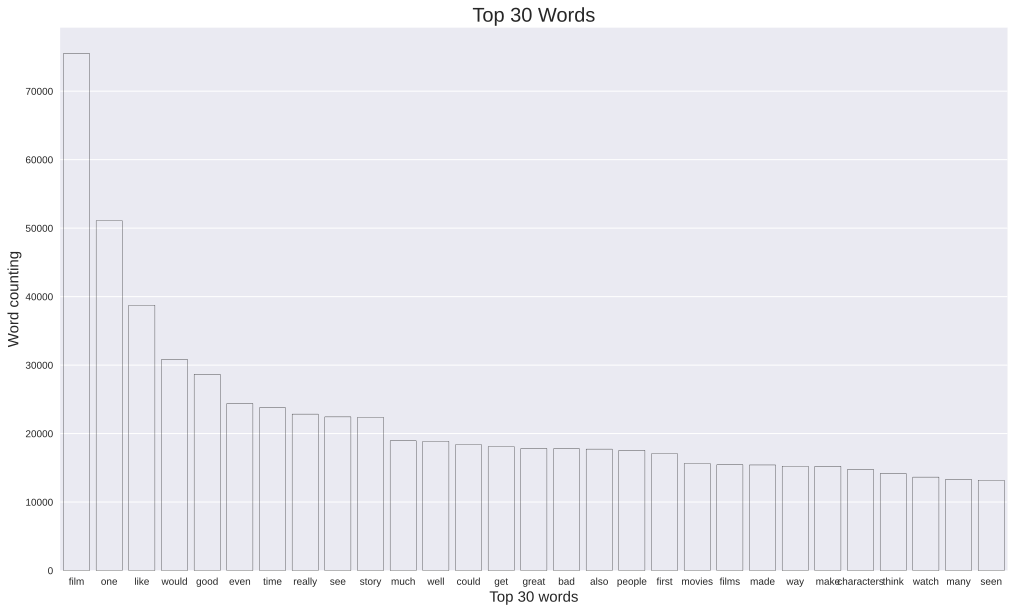

In [ ]:
draw_top_words(data=data['review'], top_size=30, title='Top')


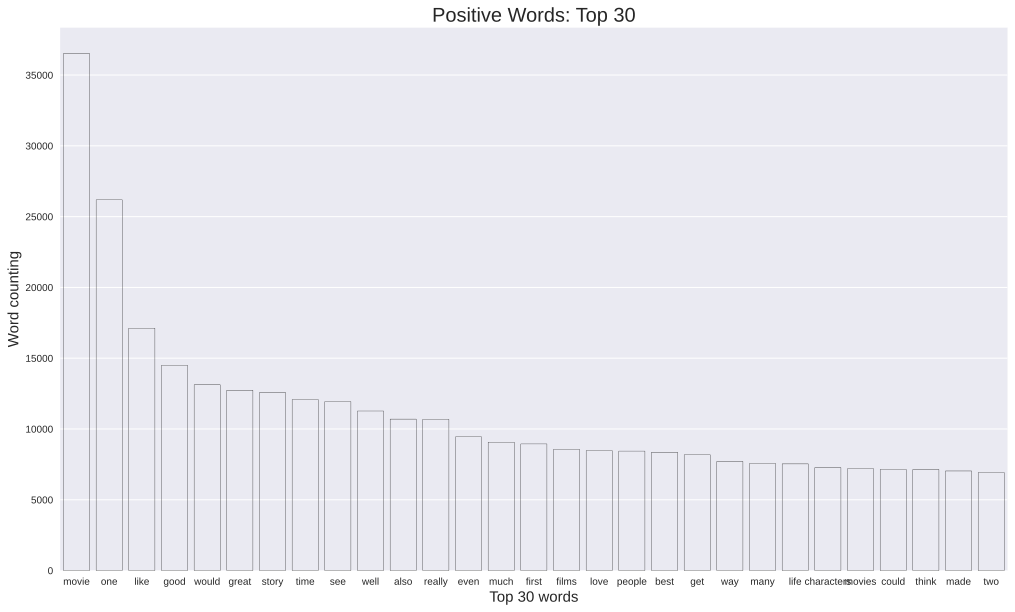

In [ ]:
draw_top_words(data=pos['review'], top_size=30, title='positive')

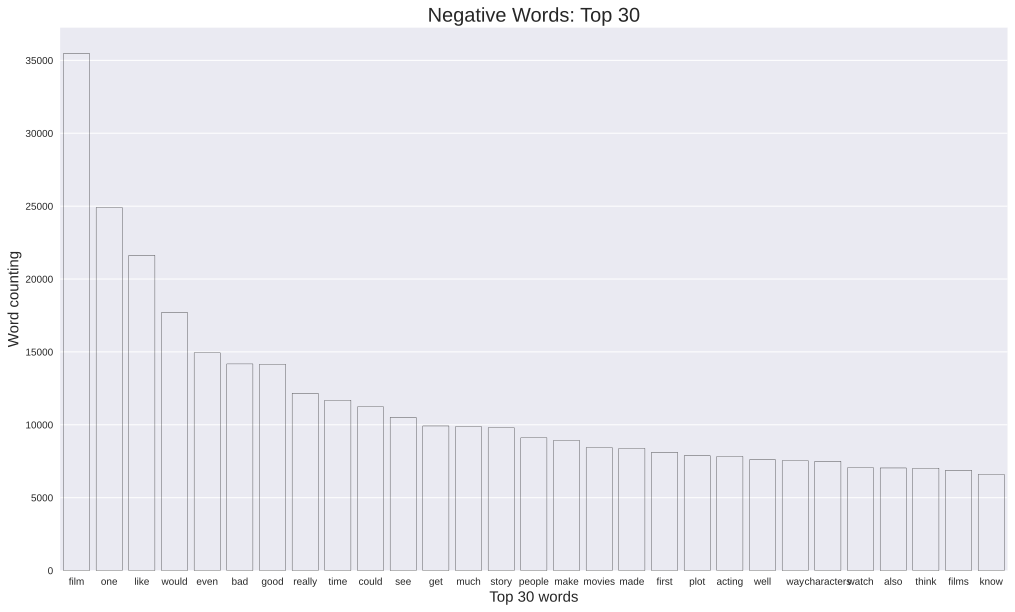

In [ ]:
draw_top_words(data=neg['review'], top_size=30, title='negative')

**Conclusion**  

* It is obvious that some words that play a big role are of little use in further training models, so it is worth deleting them.
* Words like *movie or film* are the theme which all reviews share. Thus I suppose idf(inverse document frequency) should be close to zero.

In [ ]:
COMMONWORDS = {'film', 'one', 'movie', 'like', 'would', 'time', 'see'}

def remove_common_words(text):
    """remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in COMMONWORDS])

In [ ]:
data['review'] =  data['review'].apply(lambda text: remove_common_words(text))
data.head(1)

review  \
0  reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far away say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz mess around first episode ever saw struck nasty surreal could say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches due lack street skills prison experience watching oz may become comfortable uncomfortable viewingthat get touch darker side   

  sentiment  
0  positive

Let's look at result:

In [ ]:
pos = data[data['sentiment']=='positive']
neg = data[data['sentiment']=='negative']

In [ ]:
draw_top_words(data=neg['review'], top_size=30, title='negative')

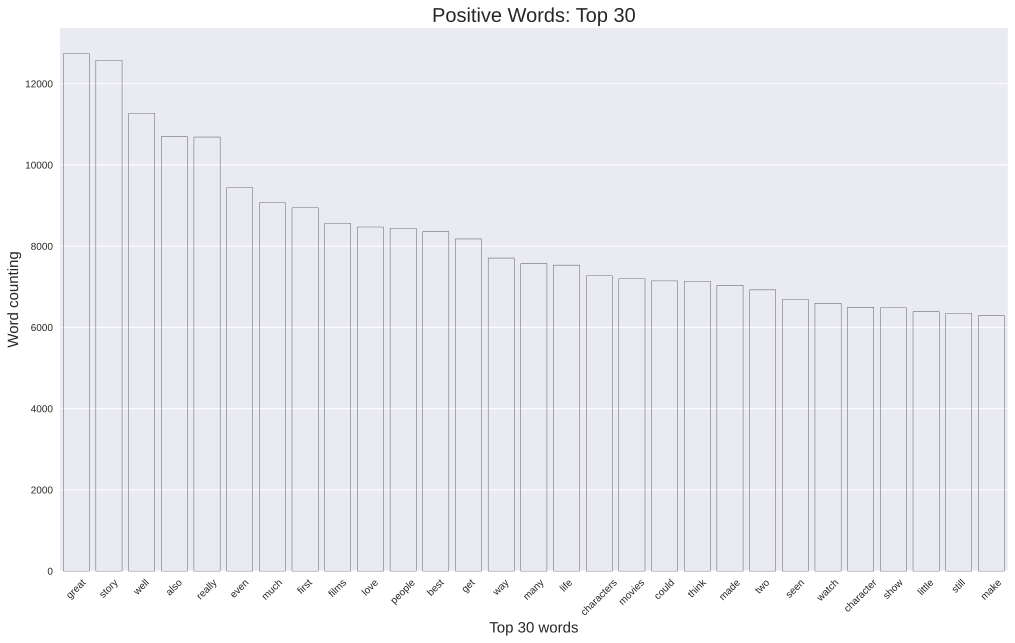

In [ ]:
draw_top_words(data=pos['review'], top_size=30, title='positive')

**Word clouds**


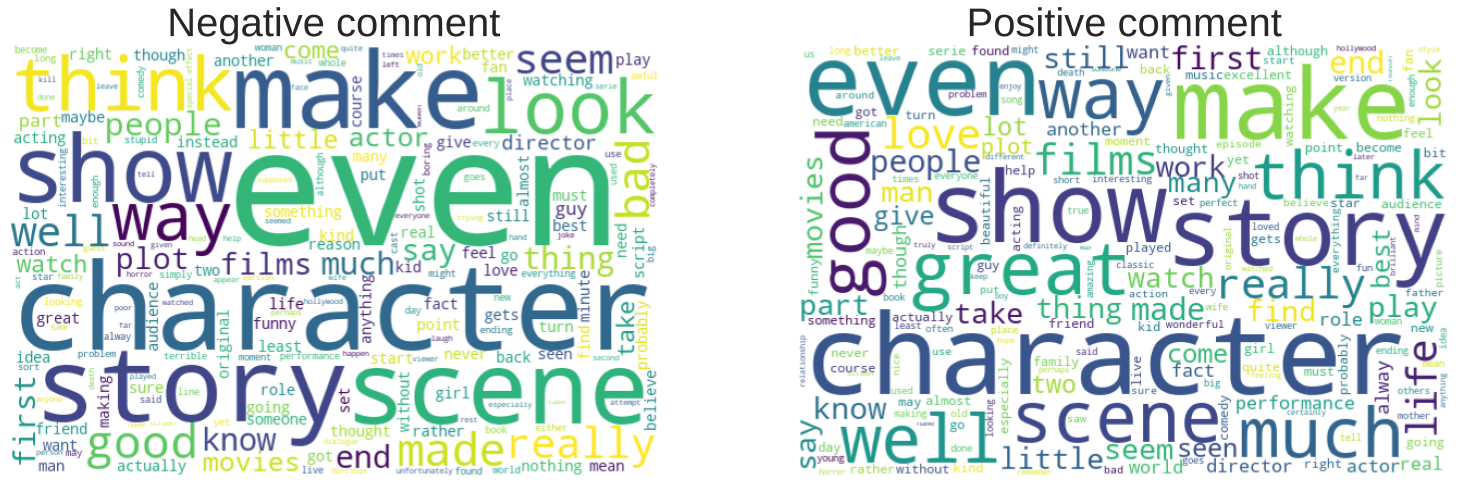

In [ ]:
draw_word_clouds(pos, neg)

**Conclusion**
* The top 30 words have changed a little for the better.
* It is noticeable that the text data is cleared, there are no tags.
* The words are different, but of course there are similarities.

The 2nd preprocessing step:

* At this stage, I wanted to remove all the written numbers from the text, since they do not play a role for the model, but the power of my computer did not allow me to do this quickly (I waited for a very long time)
* Next, it is a very good practice to correct capital errors in the text, but again the whole problem was the power of the computer and I did not wait for the code execution to finish.
* However, despite the fact that these two points were skipped, scores on the models still showed a decent result of execution, so for now you can skip these points and use other computing power in the future.

**Removal of uppercase numbers**

In [ ]:
# def remove_written_numbers(text):
#   nlp = spacy.load('en_core_web_sm')
#   doc = nlp(text)

#   tokens = [token.text for token in doc if token.pos_ != 'NUM']
#   return " ".join(tokens)

In [ ]:
# data['review'] =  data['review'].apply(lambda text: remove_written_numbers(text))
# data.head(1)

In [ ]:
# data.to_csv('/content/drive/My Drive/DA/HW6/updatedMovieDataset_drop_nums.csv',sep=',', header=True, index=True)

**Spelling Correction**  
One another important text preprocessing step is spelling correction. Typos are common in text data and we might want to correct those spelling mistakes before we do our analysis.

In this notebook, I'll use the python package *symspellpy* for this dataset spelling correction.

In [ ]:
# !pip install symspellpy

     |████████████████████████████████| 2.6 MB 8.5 MB/s 


In [ ]:
# import pkg_resources
# from symspellpy import SymSpell, Verbosity

# def spellcorrector(text):
#   sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
#   dictionary_path = pkg_resources.resource_filename(
#       "symspellpy", "frequency_dictionary_en_82_765.txt")
#   bigram_path = pkg_resources.resource_filename(
#       "symspellpy", "frequency_bigramdictionary_en_243_342.txt")
#   # term_index is the column of the term and count_index is the
#   # column of the term frequency
#   sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
#   sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)
#   # lookup suggestions for multi-word input strings (supports compound
#   # splitting & merging)
#   # max edit distance per lookup (per single word, not per whole input string)
#   suggestions = sym_spell.lookup_compound((text), max_edit_distance=2)
#   # display suggestion term, edit distance, and term frequency
#   corrected_text = ""
#   for suggestion in suggestions:
#       corrected_text =corrected_text + str(suggestion).split(",")[0]

#   return corrected_text

In [ ]:
# data['review'] = data['review'].apply(lambda text: spellcorrector(text))
# data.head(1)

In [ ]:
# data.to_csv('/content/drive/My Drive/DA/HW6/updatedMovieDataset_spelling_2stage.csv')

## **Tokenization**  

Tokenization is a process that splits an input sequence into so-called tokens where the tokens can be a word, sentence, paragraph etc.

In [ ]:
tokenizer = nltk.tokenize.TreebankWordTokenizer()
data['review'] = data['review'].apply(lambda x: tokenizer.tokenize(x))
data['review'].head(1)

0    [reviewers, mentioned, watching, oz, episode, hooked, right, exactly, happened, first, thing, struck, oz, brutality, unflinching, scenes, violence, set, right, word, go, trust, show, faint, hearted, timid, show, pulls, punches, regards, drugs, sex, violence, hardcore, classic, use, word, called, oz, nickname, given, oswald, maximum, security, state, penitentary, focuses, mainly, emerald, city, experimental, section, prison, cells, glass, fronts, face, inwards, privacy, high, agenda, city, home, manyaryans, muslims, gangstas, latinos, christians, italians, irish, moreso, scuffles, death, stares, dodgy, dealings, shady, agreements, never, far, away, say, main, appeal, show, due, fact, goes, shows, dare, forget, pretty, pictures, painted, mainstream, audiences, forget, charm, forget, romanceoz, ...]
Name: review, dtype: object

## **Normalisation (comparison of stemming and lemmatization)**

In [ ]:
data.loc[:, 'sentiment'].replace("negative", 0, inplace=True)
data.loc[:, 'sentiment'].replace("positive", 1, inplace=True)
data.head(1)

review  \
0  [reviewers, mentioned, watching, oz, episode, hooked, right, exactly, happened, first, thing, struck, oz, brutality, unflinching, scenes, violence, set, right, word, go, trust, show, faint, hearted, timid, show, pulls, punches, regards, drugs, sex, violence, hardcore, classic, use, word, called, oz, nickname, given, oswald, maximum, security, state, penitentary, focuses, mainly, emerald, city, experimental, section, prison, cells, glass, fronts, face, inwards, privacy, high, agenda, city, home, manyaryans, muslims, gangstas, latinos, christians, italians, irish, moreso, scuffles, death, stares, dodgy, dealings, shady, agreements, never, far, away, say, main, appeal, show, due, fact, goes, shows, dare, forget, pretty, pictures, painted, mainstream, audiences, forget, charm, forget, romanceoz, ...]   

   sentiment  
0          1

In [ ]:
stem_data = data.copy(deep=True)
lem_data = data.copy(deep=True)

## **Stemming**  

Stemming is a process of reducing words to their word stem, base or root form (for example, books — book, looked — look). The main algorithms used for stemming is Porter stemming algorithm.

In [ ]:
stem_data['review'] = stem_data['review'].apply(lambda text: stem_words(text))
stem_data.head(1)

review  \
0  review mention watch oz episod hook right exactli happen first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use word call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far away say main appeal show due fact goe show dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz mess around first episod ever saw struck nasti surreal could say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard sold nickel inmat kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi watch oz may becom comfort uncomfort viewingthat get touch darker side   

   sentiment  
0          1

In [ ]:
stem_data.to_csv('/content/drive/My Drive/DA/HW6/updatedMovieDataset_stemm.csv',sep=',', header=True, index=True)

**Load stemm data**

In [ ]:
drive.mount("/content/drive")
stem_data = pd.read_csv('/content/drive/My Drive/DA/HW6/updatedMovieDataset_stemm.csv', sep=',')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
stem_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49577 entries, 0 to 49576
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  49577 non-null  int64 
 1   review      49577 non-null  object
 2   sentiment   49577 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [ ]:
stem_data.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
df_add = stem_data.copy(deep=True)  # for additional part at the end of notebook

In [ ]:
df_add.head(1)

review  \
0  review mention watch oz episod hook right exactli happen first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use word call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far away say main appeal show due fact goe show dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz mess around first episod ever saw struck nasti surreal could say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard sold nickel inmat kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi watch oz may becom comfort uncomfort viewingthat get touch darker side   

   sentiment  
0          1

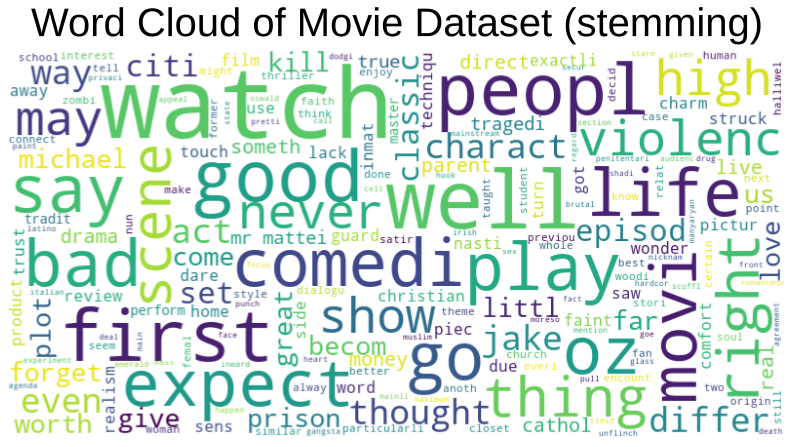

In [ ]:
from wordcloud import WordCloud, STOPWORDS


def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(12.0,10.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(stem_data["review"], title="Word Cloud of Movie Dataset (stemming)")

In [ ]:
pos = stem_data[stem_data['sentiment']==1]
neg = stem_data[stem_data['sentiment']==0]

In [ ]:
plot_wordcloud(pos, title="POSITIVE - Word Cloud of Movie Dataset (stemming)")

In [ ]:
plot_wordcloud(neg, title="NEGATIVE - Word Cloud of Movie Dataset (stemming)")

# **Baseline model**

### **Data Loader + TFIDF**


**Transforming tokens to a vector**  

After the initial preprocessing phase, we need to transform text into a meaningful vector (or array) of numbers. 

One approach is to rescale the frequency of words by how often they appear in all documents so that the scores for frequent words like “the” that are also frequent across all documents are penalized. This approach to scoring is called Term Frequency-Inverse Document Frequency, or TF-IDF for short.

In [ ]:
# Set parameters

MAX_LEN = 128 #@param [64, 128, 256, 512, 1024] {allow-input: true}
MAX_VOCAB = 1000 #@param [1000, 5000, 10000, 100000] {allow-input: true}

In [ ]:
class MovieDatasetLoader(Dataset):
    def __init__(self, data, max_vocab=5000, max_len=128, input_vectorizer='tf-idf'):
        df = data.copy(deep=True)
        
        # tokenize
        tokenizer = nltk.tokenize.TreebankWordTokenizer()


        df['tokens'] = df['review'].apply(lambda x: tokenizer.tokenize(x))
        
        all_tokens = [token for doc in list(df.tokens) for token in doc]
        
        # Build most common tokens bound by max vocab size
        common_tokens = set( 
            list(
                zip(*Counter(all_tokens).most_common(max_vocab))
            )[0] 
        )
        
        # Replace rare words with <UNK>
        df.loc[:, 'tokens'] = df.tokens.progress_apply(
            partial(
                remove_rare_words,
                common_tokens=common_tokens,
                max_len=max_len,
            ),
        )

        # Remove sequences with only <UNK>
        df = df[df.tokens.progress_apply(
            lambda tokens: any(token != '<UNK>' for token in tokens),
        )]
        
        # Build vocab
        vocab = sorted(set(
            token for doc in list(df.tokens) for token in doc
        ))
        self.token2idx = {token: idx for idx, token in enumerate(vocab)}
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}
        
        # Convert tokens to indexes
        df['indexed_tokens'] = df.tokens.progress_apply(
            lambda doc: [self.token2idx[token] for token in doc],
        )
        
        if input_vectorizer == 'tf-idf':
            # Build TF-IDF vector
            vectorizer = TfidfVectorizer(
                analyzer='word',
                tokenizer=lambda doc: doc,
                preprocessor=lambda doc: doc,
                token_pattern=None,
            )
            vectors = vectorizer.fit_transform(df.tokens).toarray()
            df['tfidf_vector'] = [vector.tolist() for vector in vectors]

        if input_vectorizer == 'word2vec':
             df['word2vec_vector'] = df['review'].apply(document_vector)
        
        self.text = df.review.tolist()
        self.sequences = df.indexed_tokens.tolist()

        if input_vectorizer == 'tf-idf':
          self.vector = df.tfidf_vector.tolist()
        if input_vectorizer == 'word2vec':
          self.vector = df.word2vec_vector.tolist()

        self.targets = df.sentiment.tolist()
    
    def __getitem__(self, i):
        return (
            self.sequences[i],
            self.vector[i],
            self.targets[i],
            self.text[i],
        )
    
    def __len__(self):
        return len(self.targets)

In [ ]:
dataset = MovieDatasetLoader(stem_data, max_vocab=MAX_VOCAB, max_len=MAX_LEN, input_vectorizer='tf-idf')

PROGRESS>>>:   0%|          | 0/49577 [00:00<?, ?it/s]

PROGRESS>>>:   0%|          | 0/49577 [00:00<?, ?it/s]

PROGRESS>>>:   0%|          | 0/49576 [00:00<?, ?it/s]

See a random sample out of the dataset processed

In [ ]:
print('Number of records:', len(dataset), '\n')

import random
random_idx = random.randint(0,len(dataset)-1)
print('index:', random_idx, '\n')
sample_seq, tfidf_vector, sample_target, sample_text = dataset[random_idx]
print(sample_text, '\n')
print(sample_seq, '\n')
print('TF-IDF vector size:', len(tfidf_vector), '\n')
print('Sentiment:', sample_target, '\n')

Number of records: 49576 

index: 31006 

saw age children section erol video anim watch whole differ ball game violent stori graphic death entertain compel children avoid famili view mom nearli heart attack rip video apart 

[745, 19, 148, 0, 0, 943, 39, 957, 970, 237, 0, 368, 948, 840, 0, 217, 281, 0, 148, 66, 317, 944, 0, 587, 409, 60, 0, 943, 47] 

TF-IDF vector size: 1001 

Sentiment: 1 



## **Split**  


- **Training**: data the model learns from
- **Validation**: data to evaluate with for hyperparameter tuning (make sure the model doesn't overfit!)
- **Testing**: data to evaluate the final performance of the model

In [ ]:
train_dataset, valid_dataset, test_dataset = split_train_valid_test(
    dataset, valid_ratio=0.05, test_ratio=0.05)
len(train_dataset), len(valid_dataset), len(test_dataset)

(44620, 2478, 2478)

In [ ]:
def collate(batch):
    seq = [item[0] for item in batch]
    vector = torch.from_numpy(np.array([item[1] for item in batch], dtype='float32')) # ADD LongTensor
    target = torch.LongTensor([item[2] for item in batch])
    text = [item[3] for item in batch]
    return seq, vector, target, text

In [ ]:
BATCH_SIZE = 528

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate)

In [ ]:
print('number of training batches:', len(train_loader), '\n')
batch_idx = random.randint(0, len(train_loader)-1)
example_idx = random.randint(0, BATCH_SIZE-1)

for i, fields in enumerate(train_loader):
    seq, tfidf, target, text = fields
    if i == batch_idx:
        print('Training input sequence:', seq[example_idx], '\n')
        print('TF-IDF vector size:', len(tfidf[example_idx]), '\n')
        print('Label: ', target[example_idx], '\n')
        print('Review text:', text[example_idx], '\n')

number of training batches: 85 

Training input sequence: [0, 338, 746, 959, 2, 0, 669, 253, 954, 422, 704, 8, 639, 482, 871, 857, 957, 389, 459, 309, 443, 0, 0, 712, 756, 3, 32, 712, 574, 0, 0, 88, 749, 444, 964, 712, 0, 211, 0, 794, 221, 903, 953, 262] 

TF-IDF vector size: 1001 

Label:  tensor(1) 

Review text: desir filmmak say way abl compet power drama war home reason act perfect know talk suggest watch got involv extrem impress estevez sheen relationship screen absolut amaz relationship mother kathi bate best scene includ well relationship sheen daughter estevez sister definit top want dvd 



## **Linear model based on TF-IDF as a baseline**

In [ ]:
is_cuda = torch.cuda.is_available()
print(f"Cuda Status on the system is {is_cuda}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Cuda Status on the system is False


In order to make the results reproducible, I have specified the seed value. Since Deep Learning model might produce different results each when it is executed due to the randomness in it, it is important to specify the seed value.

In [ ]:
#Reproducing same results
SEED = 42

#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True  

In [ ]:
class ClassifNet(nn.Module):
    def __init__(self, D_in, H, D_out):
        super(ClassifNet,self).__init__()
        self.linear1=nn.Linear(D_in,H)
        self.linear2=nn.Linear(H,D_out)
        
        
    def forward(self,x):
        x=torch.sigmoid(self.linear1(x))  
        x=self.linear2(x)
        sm=nn.Softmax(dim=-1)
        x = sm(x)
        return x

In [ ]:
def train_epoch(model, optimizer, train_loader):
    model.train()
    total_loss, total = 0, 0
    for seq, tfidf, target, text in train_loader:
    
        inputs = tfidf
        
        # Reset gradient
        optimizer.zero_grad()
        
        # Forward pass
        output = model(inputs)
        
        # Compute loss
        loss = criterion(output, target)
        
        # Perform gradient descent, backwards pass
        loss.backward()

        # Take a step in the right direction
        optimizer.step()
        scheduler.step()

        # Record metrics
        total_loss += loss.item()
        total += len(target)

    return total_loss / total


def validate_epoch(model, valid_loader):
    model.eval()
    total_loss, total = 0, 0
    with torch.no_grad():
        for seq, tfidf, target, text in valid_loader:
         
            inputs = tfidf

            # Forward pass
            output = model(inputs)

            # Calculate how wrong the model is
            loss = criterion(output, target)

            # Record metrics
            total_loss += loss.item()
            total += len(target)

    return total_loss / total

In [ ]:
input_dim=1001    
hidden_dim = 500 # hidden layers
output_dim=2    # number of classes

### **Instantiate model**

In [ ]:
clss_model=ClassifNet(input_dim,hidden_dim,output_dim)

In [ ]:
LEARNING_RATE = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, clss_model.parameters()),
    lr=LEARNING_RATE,
)
scheduler = CosineAnnealingLR(optimizer, 1)

In [ ]:
n_epochs = 0
train_losses, valid_losses = [], []
while True:
    train_loss = train_epoch(clss_model, optimizer, train_loader)
    valid_loss = validate_epoch(clss_model, valid_loader)
    
    tqdm.write(
        f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.2e}\tvalid_loss: {valid_loss:.2e}\n',
    )
    
    # Early stopping if the current valid_loss is greater than the last three valid losses
    if len(valid_losses) > 2 and all(valid_loss >= loss for loss in valid_losses[-3:]):
        print('Stopping early')
        break
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    n_epochs += 1

epoch #  1	train_loss: 1.30e-03	valid_loss: 1.34e-03

epoch #  2	train_loss: 1.22e-03	valid_loss: 1.24e-03

epoch #  3	train_loss: 1.10e-03	valid_loss: 1.12e-03

epoch #  4	train_loss: 1.01e-03	valid_loss: 1.05e-03

epoch #  5	train_loss: 9.64e-04	valid_loss: 1.01e-03

epoch #  6	train_loss: 9.33e-04	valid_loss: 9.84e-04

epoch #  7	train_loss: 9.12e-04	valid_loss: 9.67e-04

epoch #  8	train_loss: 8.98e-04	valid_loss: 9.55e-04

epoch #  9	train_loss: 8.87e-04	valid_loss: 9.46e-04

epoch # 10	train_loss: 8.79e-04	valid_loss: 9.39e-04

epoch # 11	train_loss: 8.73e-04	valid_loss: 9.33e-04

epoch # 12	train_loss: 8.67e-04	valid_loss: 9.29e-04

epoch # 13	train_loss: 8.63e-04	valid_loss: 9.25e-04

epoch # 14	train_loss: 8.59e-04	valid_loss: 9.23e-04

epoch # 15	train_loss: 8.56e-04	valid_loss: 9.20e-04

epoch # 16	train_loss: 8.53e-04	valid_loss: 9.18e-04

epoch # 17	train_loss: 8.51e-04	valid_loss: 9.17e-04

epoch # 18	train_loss: 8.48e-04	valid_loss: 9.15e-04

epoch # 19	train_loss: 8.47e

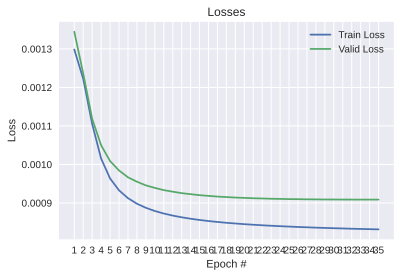

In [ ]:
epoch_ticks = range(1, n_epochs + 1)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses') 
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

**Prediction**

In [ ]:
clss_model.eval()
test_accuracy, n_examples = 0, 0
y_true, y_pred = [], []
input_type = 'tdidf'

with torch.no_grad():
    for seq, tfidf, target, text in test_loader:

        inputs = tfidf
        probs = clss_model(inputs)
        
        probs = probs.detach().cpu().numpy()
        predictions = np.argmax(probs, axis=1)
        target = target.cpu().numpy()
        
        y_true.extend(predictions)
        y_pred.extend(target)
      

calc_metrics(y_true, y_pred)

Accuracy: 0.84705 
Balanced accuracy: 0.84696 
Multiclass f1-score: 
    micro: 0.84705 
    macro: 0.84697 
    weighted: 0.84705


Classification report:

              precision    recall  f1-score   support

           0    0.84450   0.84241   0.84345      1212
           1    0.84949   0.85150   0.85049      1266

    accuracy                        0.84705      2478
   macro avg    0.84699   0.84696   0.84697      2478
weighted avg    0.84705   0.84705   0.84705      2478



**Let's check a few examples**

In [ ]:
flatten = lambda x: [sublst for lst in x for sublst in lst]
seq_lst, tfidf_lst, target_lst, text_lst = zip(*test_loader)
seq_lst, tfidf_lst, target_lst, text_lst = map(flatten, [seq_lst, tfidf_lst, target_lst, text_lst])
test_examples = list(zip(seq_lst, tfidf_lst, target_lst, text_lst))

In [ ]:
def print_random_prediction(model, n=5):
    to_emoji = lambda x: '😄' if x else '😡'
    model.eval()
    rows = []
    for i in range(n):
        with torch.no_grad():
            seq, tdidf, target, text = random.choice(test_examples)
            target = target.item()
     
            inputs = tfidf

            probs = model(inputs)
            probs = probs.detach().cpu().numpy()
            prediction = np.argmax(probs, axis=1)[0]

            predicted = to_emoji(prediction)
            actual = to_emoji(target)
            
            row = f"""
            <tr>
            <td>{i+1}&nbsp;</td>
            <td>{text}&nbsp;</td>
            <td>{predicted}&nbsp;</td>
            <td>{actual}&nbsp;</td>
            </tr>
            """
            rows.append(row)
            
    rows_joined = '\n'.join(rows)
    table = f"""
    <table>
    <tbody>
    <tr>
    <td><b>Number</b>&nbsp;</td>
    <td><b>Review</b>&nbsp;</td>
    <td><b>Predicted</b>&nbsp;</td>
    <td><b>Actual</b>&nbsp;</td>
    </tr>{rows_joined}
    </tbody>
    </table>
    """
    display(HTML(table))

In [ ]:
print_random_prediction(clss_model, n=5)

**Conclusion**

* Simple accuracy gives an excellent result-0.84, but you should not believe this estimate 100 percent, so it's worth looking at a balanced accuracy.
* Balanced Accuracy tries to account for the imbalance in the classes and outputs a value of - 0.84, which is very good.
* However, it is worth noting that our class is quite balanced and the accuracy does not differ much.
* My classifier identifies both classes very good. The values of the classes are close to 0.8. This fact is also confirmed by the *f1-score* metric.



# **RNN models**

## **Pretrained embedding (word2vec)**

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://drive.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=0B7XkCwpI5KDYNlNUTTlSS21pQmM' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=0B7XkCwpI5KDYNlNUTTlSS21pQmM" -O GoogleNews-vectors-negative300.bin.gz && rm -rf /tmp/cookies.txt
!gunzip GoogleNews-vectors-negative300.bin.gz

--2021-10-23 15:24:53--  https://drive.google.com/uc?export=download&confirm=9nZK&id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
Resolving drive.google.com (drive.google.com)... 172.217.0.46, 2607:f8b0:4004:800::200e
Connecting to drive.google.com (drive.google.com)|172.217.0.46|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-1g-docs.googleusercontent.com/docs/securesc/06ar6ecdv76vhupo9kqtuqte22jdr6il/ior1e71oulvaunt2ulon29khhsf2melo/1635002625000/06848720943842814915/05305028279417282665Z/0B7XkCwpI5KDYNlNUTTlSS21pQmM?e=download [following]
--2021-10-23 15:24:53--  https://doc-10-1g-docs.googleusercontent.com/docs/securesc/06ar6ecdv76vhupo9kqtuqte22jdr6il/ior1e71oulvaunt2ulon29khhsf2melo/1635002625000/06848720943842814915/05305028279417282665Z/0B7XkCwpI5KDYNlNUTTlSS21pQmM?e=download
Resolving doc-10-1g-docs.googleusercontent.com (doc-10-1g-docs.googleusercontent.com)... 172.217.15.65, 2607:f8b0:4004:810::2001
Connecting to doc-10-1g-docs.googl

In [ ]:
nlp = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True) #without *norm_only* param

In [ ]:
len(nlp.vocab)

3000000

**Clean data without stemming**  

I use cleaned texts without stemming to preserve the style of speech and convey the mood of the text, since I will work with pre-trained models.


In [ ]:
clean_data = pd.read_csv('/content/drive/My Drive/DA/HW6/updatedMovieDataset_1st_stage.csv', sep=',')

clean_data.loc[:, 'sentiment'].replace("negative", 0, inplace=True)
clean_data.loc[:, 'sentiment'].replace("positive", 1, inplace=True)
clean_data.head(1)

review  \
0  one reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows would dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz mess around first episode ever saw struck nasty surreal could say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches due lack street skills prison experience watching oz may become comfortable uncomfortable viewingthat get touch darker side   

   sentiment  
0          1

### **Dataset loader**

In [ ]:
class MovieDatasetLoader(Dataset):
    def __init__(self, data):
       self.df = data

    def __len__(self):
            return self.df.shape[0]

    def __getitem__(self, i):
        tens_arr = []
        tokenizer = nltk.tokenize.TreebankWordTokenizer()
        tok_txt = tokenizer.tokenize(self.df['review'][i])

        vec = conv_word2vec(tok_txt)
       
        vec = torch.from_numpy(np.array(vec, dtype='float32'))
        target = self.df['sentiment'][i]

        return vec, target

In [ ]:
dataset = MovieDatasetLoader(clean_data) 

In [ ]:
print('Number of records:', len(dataset), '\n')
import random
random_idx = random.randint(0,len(dataset)-1)
print('index:', random_idx, '\n')
vector, sample_target = dataset[random_idx]
print('Traget', sample_target, '\n')
# print(vector, '\n')
print('Word2Vec vector size:', len(vector), '\n')

Number of records: 49577 

index: 29294 

Traget 0 

Word2Vec vector size: 56 



### **Split**  
- **Training**: data the model learns from
- **Validation**: data to evaluate with for hyperparameter tuning (make sure the model doesn't overfit!)
- **Testing**: data to evaluate the final performance of the model

In [ ]:
train_dataset, valid_dataset, test_dataset = split_train_valid_test(
    dataset, valid_ratio=0.05, test_ratio=0.05)
len(train_dataset), len(valid_dataset), len(test_dataset)

(44621, 2478, 2478)

In [ ]:
def collate(batch):
    vector = [item[0] for item in batch]
    vec_lens = [len(item[0]) for item in batch]
    vector = pad_sequence(vector, batch_first=True,  padding_value=0)

    target = torch.LongTensor([item[1] for item in batch])

    return vector,vec_lens,target

In [ ]:
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate)
valid_loader = DataLoader(valid_dataset, shuffle=True,  batch_size=BATCH_SIZE, collate_fn=collate)

test_loader = DataLoader(test_dataset, shuffle=True,  batch_size=512, collate_fn=collate)

In [ ]:
for vec, vec_len, target in train_loader:
  print(vec.shape, target.shape)
  break

torch.Size([16, 282, 300]) torch.Size([16])


**Train Function**

In [ ]:
def train(model, optimizer, criterion, 
          train_loader, val_loader, 
          epochs=100, iter_per_validation=50,
          early_stopping=False,
          checkpoint_path="./best_checkpoint",
          save_by="accuracy"):
  iteration = 0
  loss_list = []
  iteration_list = []
  accuracy_list = []
  best_score = None

  for epoch in range(epochs):
      print(f"Epoch {epoch}")

      for vec, vlen, labels in train_loader:
          model.train()
          # Clear gradients
          optimizer.zero_grad()
        
          # Forward propagation
          outputs = model(vec)
      
          # Calculate softmax and ross entropy loss
          loss = criterion(outputs, labels)
          
          # Calculating gradients
          loss.backward()
          
          # Update parameters
          optimizer.step()
          
          iteration += 1
          
          if iteration % iter_per_validation == 0:
              model.eval()
              with torch.no_grad():
                # Calculate Accuracy         
                correct = 0
                total = 0
                # Iterate through test dataset

                for vec,  vlen, labels in val_loader:

                    # Forward propagation
                    outputs = model(vec)

                    # Get predictions from the maximum value
                    predicted = torch.max(outputs.data, 1)[1]
                    
                    # Total number of labels
                    total += len(labels)
                    
                    correct += (predicted == labels).sum()
                
                accuracy = 100 * correct / float(total)
            
                # store loss and iteration
                loss_list.append(loss.data)
                iteration_list.append(iteration)
                accuracy_list.append(accuracy)
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(iteration, loss.data, accuracy))

                # save if we have best model state
                ref_score = accuracy if save_by == "accuracy" else loss.data
                compare = (lambda x, y: x > y) if save_by == "accuracy" else (lambda x, y: x < y)
                if best_score is None or compare(ref_score, best_score):
                    best_score = ref_score
                    save_checkpoint(model, optimizer, 
                                    optimizer.state_dict()['param_groups'][0]['lr'], 
                                    iteration, checkpoint_path)
                    
                 # Early stopping if the current valid_loss is greater than the last three valid losses
                if  early_stopping == True:
                    if len(accuracy_list) > 3 and all(accuracy >= acc for acc in accuracy_list[-4:]):
                        print('Stopping early')
                        break

  return iteration_list, loss_list, accuracy_list

### **RNN**

In [ ]:
class RNN(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sm = nn.Softmax(dim=-1)

    def forward(self, x):
        output, hidden = self.rnn(x)

        hidden = torch.squeeze(hidden, 0)
        out = self.fc(hidden)
        out = self.sm(hidden)

        return out

In [ ]:
learning_rate = 0.01  
output_size = 2
hidden_size = 256  #  (350)
embedding_length = 300
EPOCH = 5

In [ ]:
rnn_model = RNN(embedding_length, hidden_size, output_size)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_model.parameters(),lr=learning_rate)

In [ ]:
it, losses, acs = train(rnn_model,
                        optimizer,
                        loss_fn,
                        train_loader, 
                        valid_loader,
                        EPOCH, 
                        early_stopping=True,
                        checkpoint_path='./rnn_best_checkpoint')

Epoch 0
Iteration: 50  Loss: 5.857784271240234  Accuracy: 49.919288635253906 %
Saving model and optimizer state at iteration 50 to ./rnn_best_checkpoint
Iteration: 100  Loss: 5.858044147491455  Accuracy: 50.20177459716797 %
Saving model and optimizer state at iteration 100 to ./rnn_best_checkpoint
Iteration: 150  Loss: 5.857807159423828  Accuracy: 49.03147888183594 %
Iteration: 200  Loss: 5.855597019195557  Accuracy: 48.1436653137207 %
Iteration: 250  Loss: 5.858494758605957  Accuracy: 48.748992919921875 %
Iteration: 300  Loss: 5.855214595794678  Accuracy: 49.71751403808594 %
Stopping early
Epoch 1
Iteration: 350  Loss: 5.854856014251709  Accuracy: 49.03147888183594 %
Iteration: 400  Loss: 5.854952812194824  Accuracy: 50.04035568237305 %
Stopping early
Epoch 2
Iteration: 450  Loss: 5.857474327087402  Accuracy: 50.16141891479492 %
Stopping early
Epoch 3
Iteration: 500  Loss: 5.858023643493652  Accuracy: 48.950767517089844 %
Iteration: 550  Loss: 5.858139514923096  Accuracy: 49.677158355

**Visualization**

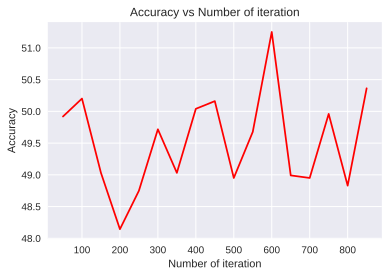

In [ ]:
draw_visualization(it, losses, acs)

**Prediction**

In [ ]:
_ = load_checkpoint('./rnn_best_checkpoint', rnn_model, optimizer)

Loading checkpoint './rnn_best_checkpoint'
Loaded checkpoint './rnn_best_checkpoint' from iteration 600


In [ ]:
test_vec, vlen, test_lbls = next(iter(test_loader))

with torch.no_grad(): 
  test_outputs = rnn_model(test_vec)

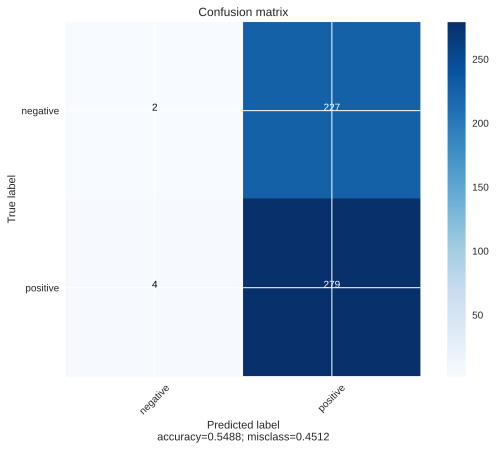

Accuracy: 0.54883 
Balanced accuracy: 0.4973 
Multiclass f1-score: 
    micro: 0.54883 
    macro: 0.36212 
    weighted: 0.39852


Classification report:

              precision    recall  f1-score   support

           0    0.33333   0.00873   0.01702       229
           1    0.55138   0.98587   0.70722       283

    accuracy                        0.54883       512
   macro avg    0.44236   0.49730   0.36212       512
weighted avg    0.45386   0.54883   0.39852       512



In [ ]:
predicted = torch.max(test_outputs.data,1)[1]  # [1]

calc_metrics(test_lbls, predicted)

**Conclusion** 

* The RNN model doesn't cope with this task. I think that this pre-trained embedding finds extremely few words from our dataset, that is why the scores are so low. I also think that a longer training session is needed for such a large dataset + GPU connection (it could not be obtained from google colab ;((( )

* Simple **accuracy** gives an awefull result-0.54, but you should not believe this estimate 100 percent, so it's worth looking at a balanced accuracy.

* **Balanced Accuracy** tries to account for the imbalance in the classes and outputs a value of - 0.49, which is still bad.

* My classifier identifies one class pretty good -  0.7 and the 2nd one - bad (0.01 - doesn't identify at all), which is very bad. This fact is also confirmed by the **f1-score** metric. 

### **LSTM**

In [ ]:
class LSTMNet(nn.Module):
    def __init__(self, output_dim,hidden_dim,embedding_dim):
        super(LSTMNet,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
   
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=self.hidden_dim,
                            batch_first=True)
        
        # linear and softmax layer
        self.fc = nn.Linear(self.hidden_dim, self.output_dim)

        self.sm = nn.Softmax(dim=-1)
        
    def forward(self,x):
        batch_size = x.size(0)

        # lstm_out
        output, (h_n, c_n) = self.lstm(x)

        c_n = torch.squeeze(c_n, 0)

        # fully connected layer
        out = self.fc(c_n)

        # softmax function
        sm_out = self.sm(out)
      
        return sm_out

**Params**

In [ ]:
learning_rate = 0.001 
output_size = 2
hidden_size = 350  # 256 
embedding_length = 300
EPOCH = 5

**Init model**

In [ ]:
lstm_model = LSTMNet(output_dim=output_size, hidden_dim=hidden_size, embedding_dim=embedding_length)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(),lr=learning_rate)

In [ ]:
it, losses, acs = train(lstm_model,
                        optimizer,
                        loss_fn,
                        train_loader, 
                        valid_loader,
                        EPOCH, 
                        early_stopping=True,
                        checkpoint_path='./lstm_best_checkpoint')

Epoch 0
Iteration: 50  Loss: 0.6923295855522156  Accuracy: 50.92816925048828 %
Saving model and optimizer state at iteration 50 to ./lstm_best_checkpoint
Iteration: 100  Loss: 0.6854293942451477  Accuracy: 50.84745788574219 %
Iteration: 150  Loss: 0.6831254363059998  Accuracy: 50.84745788574219 %
Iteration: 200  Loss: 0.6944724321365356  Accuracy: 49.636802673339844 %
Stopping early
Epoch 1
Iteration: 250  Loss: 0.7019575834274292  Accuracy: 50.887813568115234 %
Stopping early
Epoch 2
Iteration: 300  Loss: 0.6755058765411377  Accuracy: 50.12106704711914 %
Stopping early
Epoch 3
Iteration: 350  Loss: 0.69359290599823  Accuracy: 50.92816925048828 %
Stopping early
Epoch 4
Iteration: 400  Loss: 0.7018342018127441  Accuracy: 50.564971923828125 %
Stopping early


**Visualization**

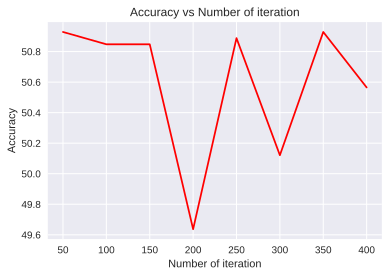

In [ ]:
draw_visualization(it, losses, acs)

**Prediction**

In [ ]:
_ = load_checkpoint('./lstm_best_checkpoint', lstm_model, optimizer)

Loading checkpoint './lstm_best_checkpoint'
Loaded checkpoint './lstm_best_checkpoint' from iteration 50


In [ ]:
test_vec, vlen, test_lbls = next(iter(test_loader))

with torch.no_grad(): 
  test_outputs = lstm_model(test_vec)

In [ ]:
predicted = torch.max(test_outputs.data,1)[1]  # [1]
predicted

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
calc_metrics(test_lbls, predicted)

Accuracy: 0.49805 
Balanced accuracy: 0.5 
Multiclass f1-score: 
    micro: 0.49805 
    macro: 0.33246 
    weighted: 0.33117


Classification report:

              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000       257
           1    0.49805   1.00000   0.66493       255

    accuracy                        0.49805       512
   macro avg    0.24902   0.50000   0.33246       512
weighted avg    0.24805   0.49805   0.33117       512



**Conclusion** 

* The LSTM model doesn't cope with this task. I think that this pre-trained embedding finds extremely few words from our dataset, that is why the scores are so low. I also think that a longer training session is needed for such a large dataset + GPU connection (it could not be obtained from google colab ;((( )

* Simple **accuracy** gives an awefull result-0.49, but you should not believe this estimate 100 percent, so it's worth looking at a balanced accuracy.

* **Balanced Accuracy** tries to account for the imbalance in the classes and outputs a value of - 0.5, which is still bad.

* My classifier identifies one class (a little bit higher then random model) -  0.6 and the 2nd one - bad (0.0 - doesn't identify at all), which is very bad. This fact is also confirmed by the **f1-score** metric. 



### **Bidirectional LSTM**

In [ ]:
class BiLSTM(nn.Module):
    def __init__(self, embedding_length, hidden_dim=128, lstm_layer=2, dropout=0.2):
        super(BiLSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(p=dropout)

        self.lstm = nn.LSTM(input_size=embedding_length,
                            hidden_size=hidden_dim,
                            num_layers=lstm_layer, 
                            dropout = dropout,
                            bidirectional=True,
                            batch_first=True)
        
        self.hidden2label = nn.Linear(hidden_dim*lstm_layer*2, 2)
        self.sm = nn.Softmax(dim=-1)
    
    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x)
        out = self.hidden2label(self.dropout(torch.cat([c_n[i,:, :] for i in range(c_n.shape[0])], dim=1)))
        sm_out = self.sm(out)
        
        return sm_out

In [ ]:
learning_rate = 0.001  # 0.001
batch_size = 16
output_size = 2
hidden_size = 128  # (350)
embedding_length = 300
EPOCH = 5

In [ ]:
bilstm_model =  BiLSTM(embedding_length)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bilstm_model.parameters(),lr=learning_rate)

In [ ]:
it, losses, acs = train(bilstm_model,
                        optimizer,
                        loss_fn,
                        train_loader, 
                        valid_loader,
                        EPOCH, 
                        early_stopping=True,
                        checkpoint_path='./bilstm_best_checkpoint')

Epoch 0
Iteration: 50  Loss: 0.6726053953170776  Accuracy: 56.416465759277344 %
Saving model and optimizer state at iteration 50 to ./bilstm_best_checkpoint
Iteration: 100  Loss: 0.6770185828208923  Accuracy: 70.0564956665039 %
Saving model and optimizer state at iteration 100 to ./bilstm_best_checkpoint
Iteration: 150  Loss: 0.6248787641525269  Accuracy: 69.08797454833984 %
Iteration: 200  Loss: 0.8132617473602295  Accuracy: 50.686038970947266 %
Stopping early
Epoch 1
Iteration: 250  Loss: 0.7507616877555847  Accuracy: 50.686038970947266 %
Stopping early
Epoch 2
Iteration: 300  Loss: 0.7507617473602295  Accuracy: 50.686038970947266 %
Stopping early
Epoch 3
Iteration: 350  Loss: 0.8132618069648743  Accuracy: 50.686038970947266 %
Stopping early
Epoch 4
Iteration: 400  Loss: 0.6882616877555847  Accuracy: 50.686038970947266 %
Stopping early


**Visualization**

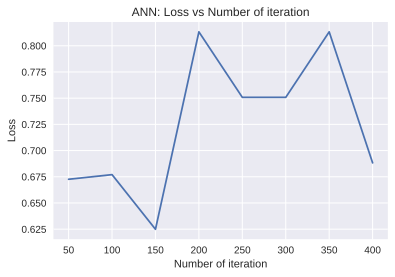

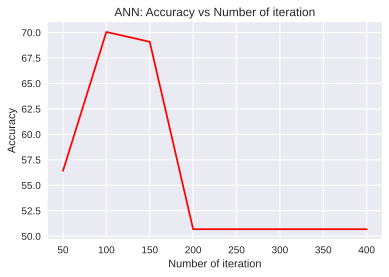

In [ ]:
draw_visualization(it, losses, acs)

**Prediction**

In [ ]:
_ = load_checkpoint('./bilstm_best_checkpoint', bilstm_model, optimizer)

Loading checkpoint './bilstm_best_checkpoint'
Loaded checkpoint './bilstm_best_checkpoint' from iteration 100


In [ ]:
test_vec, vlen, test_lbls = next(iter(test_loader))

with torch.no_grad(): 
  test_outputs = bilstm_model(test_vec)

In [ ]:
predicted = torch.max(test_outputs.data,1)[1]  # [1]
predicted

tensor([1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1])

In [ ]:
calc_metrics(test_lbls, predicted)

Accuracy: 0.3125 
Balanced accuracy: 0.29365 
Multiclass f1-score: 
    micro: 0.3125 
    macro: 0.28745 
    weighted: 0.30415


Classification report:

              precision    recall  f1-score   support

           0    0.40000   0.44444   0.42105         9
           1    0.16667   0.14286   0.15385         7

    accuracy                        0.31250        16
   macro avg    0.28333   0.29365   0.28745        16
weighted avg    0.29792   0.31250   0.30415        16



**Conclusion** 

* The LSTM model doesn't cope with this task. I think that this pre-trained embedding finds extremely few words from our dataset, that is why the scores are so low. I also think that a longer training session is needed for such a large dataset + GPU connection (it could not be obtained from google colab ;((( )

* Simple **accuracy** gives an awefull result-0.31, but you should not believe this estimate 100 percent, so it's worth looking at a balanced accuracy.

* **Balanced Accuracy** tries to account for the imbalance in the classes and outputs a value of - 0.29, which is still bad.

* My classifier identifies one class (a little bit higher then random model) -  0.49 and the 2nd one - bad (0.15 - doesn't identify at all), which is very bad. This fact is also confirmed by the **f1-score** metric. 

### **GRU**

In [ ]:
class GRUNet(torch.nn.Module):
    def __init__(self, embedding_dim,hidden_size=256,out_neuron=2):
        super(GRUNet,self).__init__()

        self.gru = torch.nn.GRU(embedding_dim,hidden_size, batch_first=True)
        self.dropout = torch.nn.Dropout(0.2) 
        self.dense = nn.Linear(hidden_size,out_neuron)
        self.sm = nn.Softmax(dim=-1)

    def forward(self,x):

        out, hidden = self.gru(x)

        y = self.dense(self.dropout(torch.cat([hidden[i,:, :] for i in range(hidden.shape[0])], dim=1)))
       
        sm_out = self.sm(y)
        return sm_out

In [ ]:
learning_rate = 0.005  # 0.001
output_size = 2
# hidden_size = 128  # (350)
embedding_length = 300
EPOCH = 5

In [ ]:
gru_model =  GRUNet(embedding_length,hidden_size=128)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gru_model.parameters(),lr=learning_rate)

In [ ]:
it, losses, acs = train(gru_model,
                        optimizer,
                        loss_fn,
                        train_loader, 
                        valid_loader,
                        EPOCH, 
                        early_stopping=True,
                        checkpoint_path='./gru_best_checkpoint')

Epoch 0
Iteration: 50  Loss: 0.6762024164199829  Accuracy: 51.0895881652832 %
Saving model and optimizer state at iteration 50 to ./gru_best_checkpoint
Iteration: 100  Loss: 0.7096562385559082  Accuracy: 49.51573944091797 %
Iteration: 150  Loss: 0.703053891658783  Accuracy: 49.03147888183594 %
Iteration: 200  Loss: 0.7130264043807983  Accuracy: 50.20177459716797 %
Iteration: 250  Loss: 0.7293835878372192  Accuracy: 50.080711364746094 %
Iteration: 300  Loss: 0.7051506042480469  Accuracy: 50.80710220336914 %
Stopping early
Epoch 1
Iteration: 350  Loss: 0.6627932190895081  Accuracy: 50.92816925048828 %
Stopping early
Epoch 2
Iteration: 400  Loss: 0.687230110168457  Accuracy: 51.493141174316406 %
Saving model and optimizer state at iteration 400 to ./gru_best_checkpoint
Stopping early
Epoch 3
Iteration: 450  Loss: 0.6644135117530823  Accuracy: 51.53349304199219 %
Saving model and optimizer state at iteration 450 to ./gru_best_checkpoint
Stopping early
Epoch 4
Iteration: 500  Loss: 0.727219

**Visualization**

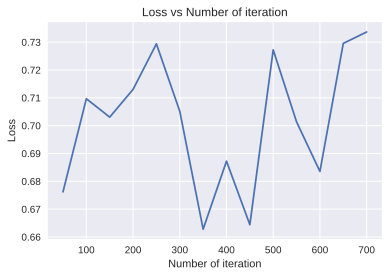

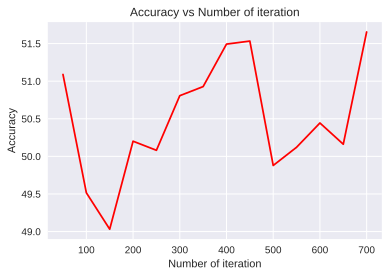

In [ ]:
draw_visualization(it, losses, acs)

**Prediction**

In [ ]:
_ = load_checkpoint('./gru_best_checkpoint', gru_model, optimizer)

Loading checkpoint './gru_best_checkpoint'
Loaded checkpoint './gru_best_checkpoint' from iteration 700


In [ ]:
test_vec, vlen, test_lbls = next(iter(test_loader))

with torch.no_grad(): 
  test_outputs = gru_model(test_vec)

In [ ]:
predicted = torch.max(test_outputs.data,1)[1]  # [1]
predicted

calc_metrics(test_lbls, predicted)

Accuracy: 0.49805 
Balanced accuracy: 0.5 
Multiclass f1-score: 
    micro: 0.49805 
    macro: 0.33246 
    weighted: 0.33117


Classification report:

              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000       257
           1    0.49805   1.00000   0.66493       255

    accuracy                        0.49805       512
   macro avg    0.24902   0.50000   0.33246       512
weighted avg    0.24805   0.49805   0.33117       512



**Conclusion** 

* The LSTM model doesn't cope with this task. I think that this pre-trained embedding finds extremely few words from our dataset, that is why the scores are so low. I also think that a longer training session is needed for such a large dataset + GPU connection (it could not be obtained from google colab ;((( )

* Simple **accuracy** gives an awefull result-0.49, but you should not believe this estimate 100 percent, so it's worth looking at a balanced accuracy.

* **Balanced Accuracy** tries to account for the imbalance in the classes and outputs a value of - 0.5, which is still bad.

* My classifier identifies one class (a little bit higher then random model) -  0.66 and the 2nd one - bad (0.0 - doesn't identify at all), which is very bad. This fact is also confirmed by the **f1-score** metric. 



## **Glove Embedding**

Try another pre-trained embedding

In [ ]:
corpus_glove = api.load('glove-twitter-200')

[==================================================] 100.0% 758.5/758.5MB downloaded


In [ ]:
len(corpus_glove.vocab)

1193514

### **Dataset Loader**

In [ ]:
def conv_glove(doc, glv):
    """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
    doc = [word for word in doc if word in glv.wv.vocab]
    return glv[doc]

In [ ]:
class MovieDatasetLoaderGlove(Dataset):
    def __init__(self, data, glv):
       self.df = data
       self.glv = glv

    def __len__(self):
            return self.df.shape[0]

    def __getitem__(self, i):
        tens_arr = []
        tokenizer = nltk.tokenize.TreebankWordTokenizer()
        tok_txt = tokenizer.tokenize(self.df['review'][i])
    
        vec = conv_glove(tok_txt, self.glv)

       
        vec = torch.from_numpy(np.array(vec, dtype='float32'))
        target = self.df['sentiment'][i]

        return vec, target

In [ ]:
dataset = MovieDatasetLoaderGlove(clean_data, corpus_glove)

In [ ]:
print('Number of records:', len(dataset), '\n')
import random
random_idx = random.randint(0,len(dataset)-1)
print('index:', random_idx, '\n')
vector, sample_target = dataset[random_idx]
print('Traget', sample_target, '\n')
# print(vector, '\n')
print('Word2Vec vector size:', len(vector), '\n')

Number of records: 49577 

index: 16617 

Traget 1 

Word2Vec vector size: 118 



### **Split**

In [ ]:
train_dataset, valid_dataset, test_dataset = split_train_valid_test(
    dataset, valid_ratio=0.05, test_ratio=0.05)
len(train_dataset), len(valid_dataset), len(test_dataset)

(44621, 2478, 2478)

In [ ]:
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate)
valid_loader = DataLoader(valid_dataset, shuffle=True,  batch_size=BATCH_SIZE, collate_fn=collate)
test_loader = DataLoader(test_dataset, shuffle=True,  batch_size=512, collate_fn=collate)

In [ ]:
for vec, vec_len, target in train_loader:
  print(vec.shape, target.shape)
  break

torch.Size([16, 364, 200]) torch.Size([16])


### **LSTM**

In [ ]:
learning_rate = 0.001 
batch_size = 16
output_size = 2
hidden_size = 128  # 256 
embedding_length = 200
EPOCH = 5

In [ ]:
lstm_model_glv = LSTMNet(output_dim=output_size, hidden_dim=hidden_size, embedding_dim=embedding_length)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model_glv.parameters(),lr=learning_rate)

In [ ]:
it, losses, acs = train(lstm_model_glv,
                        optimizer,
                        loss_fn,
                        train_loader, 
                        valid_loader,
                        EPOCH, 
                        early_stopping=True,
                        checkpoint_path='./lstm_best_checkpoint')

Epoch 0
Iteration: 50  Loss: 0.6990389227867126  Accuracy: 51.8563346862793 %
Saving model and optimizer state at iteration 50 to ./lstm_best_checkpoint
Iteration: 100  Loss: 0.6946350932121277  Accuracy: 51.93704605102539 %
Saving model and optimizer state at iteration 100 to ./lstm_best_checkpoint
Iteration: 150  Loss: 0.6942852735519409  Accuracy: 52.13882064819336 %
Saving model and optimizer state at iteration 150 to ./lstm_best_checkpoint
Iteration: 200  Loss: 0.714211106300354  Accuracy: 52.21953201293945 %
Saving model and optimizer state at iteration 200 to ./lstm_best_checkpoint
Stopping early
Epoch 1
Iteration: 250  Loss: 0.6936466693878174  Accuracy: 51.73527145385742 %
Iteration: 300  Loss: 0.6826303601264954  Accuracy: 52.46166229248047 %
Saving model and optimizer state at iteration 300 to ./lstm_best_checkpoint
Stopping early
Epoch 2
Iteration: 350  Loss: 0.689924418926239  Accuracy: 49.233253479003906 %
Iteration: 400  Loss: 0.6738579273223877  Accuracy: 49.59644699096

**Visualization**

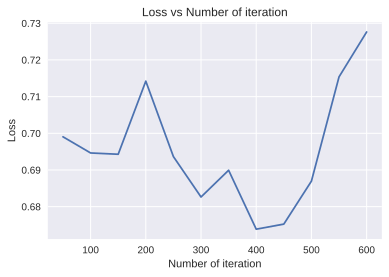

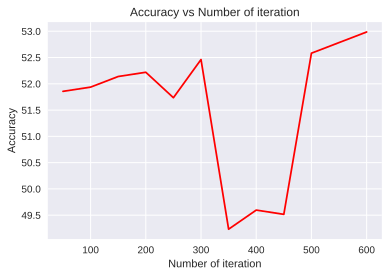

In [ ]:
draw_visualization(it, losses, acs)

**Prediction**

In [ ]:
_ = load_checkpoint('./lstm_best_checkpoint', lstm_model_glv, optimizer)

Loading checkpoint './lstm_best_checkpoint'
Loaded checkpoint './lstm_best_checkpoint' from iteration 900


In [ ]:
test_vec, vlen, test_lbls = next(iter(test_loader))

with torch.no_grad(): 
  test_outputs = lstm_model_glv(test_vec)

In [ ]:
predicted = torch.max(test_outputs.data,1)[1]  # [1]
predicted

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

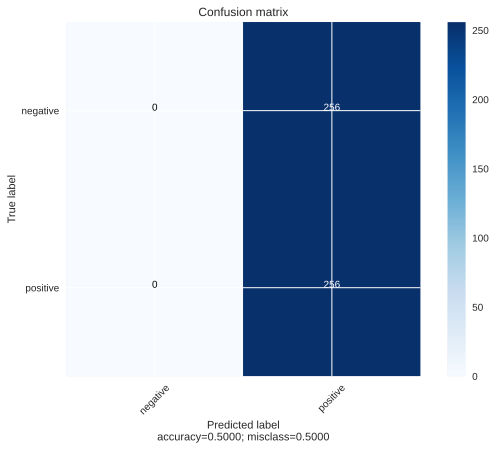

Accuracy: 0.5 
Balanced accuracy: 0.5 
Multiclass f1-score: 
    micro: 0.5 
    macro: 0.33333 
    weighted: 0.33333


Classification report:

              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000       256
           1    0.50000   1.00000   0.66667       256

    accuracy                        0.50000       512
   macro avg    0.25000   0.50000   0.33333       512
weighted avg    0.25000   0.50000   0.33333       512



In [ ]:
calc_metrics(test_lbls, predicted)

**Conclusion** 

* The LSTM model doesn't cope with this task. I think that this pre-trained embedding finds extremely few words from our dataset, that is why the scores are so low. I also think that a longer training session is needed for such a large dataset + GPU connection (it could not be obtained from google colab ;((( )

* Simple **accuracy** gives an awefull result-0.5, but you should not believe this estimate 100 percent, so it's worth looking at a balanced accuracy.

* **Balanced Accuracy** tries to account for the imbalance in the classes and outputs a value of - 0.5, which is still bad.

* My classifier identifies one class (a little bit higher then random model) -  0.66 and the 2nd one - bad (0.0 - doesn't identify at all), which is very bad. This fact is also confirmed by the **f1-score** metric. 



### **Bidirectional LSTM**

In [ ]:
learning_rate = 0.001  # 0.001
batch_size = 16
output_size = 2
hidden_size = 128  # (350)
embedding_length = 200
EPOCH = 5

In [ ]:
bilstm_model_glv =  BiLSTM(embedding_length=embedding_length)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bilstm_model_glv.parameters(),lr=learning_rate)

In [ ]:
it, losses, acs = train(bilstm_model_glv,
                        optimizer,
                        loss_fn,
                        train_loader, 
                        valid_loader,
                        EPOCH, 
                        early_stopping=True,
                        checkpoint_path='./bilstm_glv_best_checkpoint')

Epoch 0
Iteration: 50  Loss: 0.6258724927902222  Accuracy: 55.52865219116211 %
Saving model and optimizer state at iteration 50 to ./bilstm_glv_best_checkpoint
Iteration: 100  Loss: 0.8757617473602295  Accuracy: 51.97740173339844 %
Iteration: 150  Loss: 0.5632615685462952  Accuracy: 52.017757415771484 %
Iteration: 200  Loss: 0.8757617473602295  Accuracy: 51.97740173339844 %
Iteration: 250  Loss: 0.8757617473602295  Accuracy: 52.017757415771484 %
Stopping early
Epoch 1
Iteration: 300  Loss: 0.6882609724998474  Accuracy: 52.46166229248047 %
Stopping early
Epoch 2
Iteration: 350  Loss: 0.8132615685462952  Accuracy: 52.54237365722656 %
Stopping early
Epoch 3
Iteration: 400  Loss: 0.8132616877555847  Accuracy: 52.86521530151367 %
Stopping early
Epoch 4
Iteration: 450  Loss: 0.8132616281509399  Accuracy: 52.58272933959961 %
Iteration: 500  Loss: 0.6882616877555847  Accuracy: 53.309120178222656 %
Stopping early


**Visualization**

In [ ]:
draw_visualization(it, losses, acs)

**Prediction**

In [ ]:
_ = load_checkpoint('./bilstm_glv_best_checkpoint', bilstm_model_glv, optimizer)

Loading checkpoint './bilstm_glv_best_checkpoint'
Loaded checkpoint './bilstm_glv_best_checkpoint' from iteration 50


In [ ]:
test_vec, vlen, test_lbls = next(iter(test_loader))

with torch.no_grad(): 
  test_outputs = bilstm_model_glv(test_vec)

In [ ]:
predicted = torch.max(test_outputs.data,1)[1]  # [1]
predicted 

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,

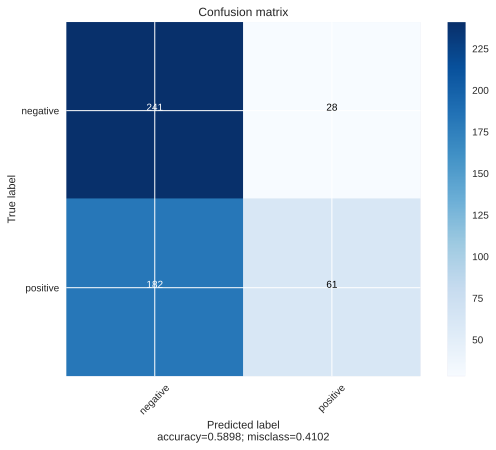

Accuracy: 0.58984 
Balanced accuracy: 0.57347 
Multiclass f1-score: 
    micro: 0.58984 
    macro: 0.532 
    weighted: 0.54036


Classification report:

              precision    recall  f1-score   support

           0    0.56974   0.89591   0.69653       269
           1    0.68539   0.25103   0.36747       243

    accuracy                        0.58984       512
   macro avg    0.62757   0.57347   0.53200       512
weighted avg    0.62463   0.58984   0.54036       512



In [ ]:
calc_metrics(test_lbls, predicted)

**Conclusion** 

* This model doesn't cope with this task. I think that this pre-trained embedding finds extremely few words from our dataset, that is why the scores are so low. I also think that a longer training session is needed for such a large dataset + GPU connection (it could not be obtained from google colab ;((( )

* Simple **accuracy** gives an bad result-0.58, but you should not believe this estimate 100 percent, so it's worth looking at a balanced accuracy.

* **Balanced Accuracy** tries to account for the imbalance in the classes and outputs a value of - 0.57, which is still bad.

* My classifier identifies one class (a little bit higher then random model) -  0.69 and the 2nd one - bad (0.4 - doesn't identify at all), which is very bad. This fact is also confirmed by the **f1-score** metric. 



# **Make own vocab by train word2vec model**

In [ ]:
corpus = []

for i in range(clean_data.shape[0]):
   tokenizer = nltk.tokenize.TreebankWordTokenizer()
   tok_txt = tokenizer.tokenize(clean_data['review'][i])
   corpus.append(tok_txt)


In [ ]:
from gensim.models import Word2Vec

In [ ]:
w2v_model = Word2Vec(corpus, size=300, window=10, min_count=1, workers=4)

In [ ]:
len(w2v_model.wv.vocab)

161755

### **Dataset Loader**

In [ ]:
def conv_word2vec(doc, w2v_model):
    """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
    doc = [word for word in doc if word in w2v_model.wv.vocab]
    return w2v_model[doc]

In [ ]:
class MovieDatasetLoader(Dataset):
    def __init__(self, data, w2v_model):
       self.df = data
       self.w2v_model = w2v_model

    def __len__(self):
            return self.df.shape[0]

    def __getitem__(self, i):
        tens_arr = []
        tokenizer = nltk.tokenize.TreebankWordTokenizer()
        tok_txt = tokenizer.tokenize(self.df['review'][i])

        vec = conv_word2vec(tok_txt, self.w2v_model)
       
        vec = torch.from_numpy(np.array(vec, dtype='float32'))
        target = self.df['sentiment'][i]

        return vec, target

In [ ]:
dataset = MovieDatasetLoader(stem_data, w2v_model) 

In [ ]:
print('Number of records:', len(dataset), '\n')
import random
random_idx = random.randint(0,len(dataset)-1)
print('index:', random_idx, '\n')
vector, sample_target = dataset[random_idx]
print('Traget', sample_target, '\n')
# print(vector, '\n')
print('Word2Vec vector size:', len(vector), '\n')

Number of records: 49577 

index: 29757 

Traget 0 

Word2Vec vector size: 63 



### **Split**

In [ ]:
train_dataset, valid_dataset, test_dataset = split_train_valid_test(
    dataset, valid_ratio=0.05, test_ratio=0.05)
len(train_dataset), len(valid_dataset), len(test_dataset)

(44621, 2478, 2478)

In [ ]:
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate)
valid_loader = DataLoader(valid_dataset, shuffle=True,  batch_size=BATCH_SIZE, collate_fn=collate)
test_loader = DataLoader(test_dataset, shuffle=True,  batch_size=512, collate_fn=collate)

In [ ]:
for vec, vec_len, target in train_loader:
  print(vec.shape, target.shape)
  break

torch.Size([16, 289, 300]) torch.Size([16])


### **LSTM**

In [ ]:
learning_rate = 0.005 # 
batch_size = 16
output_size = 2
hidden_size = 256  # 256 
embedding_length = 300
EPOCH = 5

In [ ]:
lstm_model_w2v = LSTMNet(output_dim=output_size, hidden_dim=hidden_size, embedding_dim=embedding_length)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model_w2v.parameters(),lr=learning_rate)

In [ ]:
it, losses, acs = train(lstm_model_w2v,
                        optimizer,
                        loss_fn,
                        train_loader, 
                        valid_loader,
                        EPOCH, 
                        # early_stopping=True,
                        checkpoint_path='./lstm_w2v_best_checkpoint')

Epoch 0
Iteration: 50  Loss: 0.7507617473602295  Accuracy: 51.12994384765625 %
Saving model and optimizer state at iteration 50 to ./lstm_w2v_best_checkpoint
Iteration: 100  Loss: 0.9382617473602295  Accuracy: 50.887813568115234 %
Iteration: 150  Loss: 0.8744258284568787  Accuracy: 51.45278549194336 %
Saving model and optimizer state at iteration 150 to ./lstm_w2v_best_checkpoint
Iteration: 200  Loss: 0.6255651712417603  Accuracy: 51.694915771484375 %
Saving model and optimizer state at iteration 200 to ./lstm_w2v_best_checkpoint
Iteration: 250  Loss: 0.8757618069648743  Accuracy: 51.65456008911133 %
Iteration: 300  Loss: 0.8132746815681458  Accuracy: 51.61420440673828 %
Iteration: 350  Loss: 0.8132617473602295  Accuracy: 51.73527145385742 %
Saving model and optimizer state at iteration 350 to ./lstm_w2v_best_checkpoint
Iteration: 400  Loss: 0.9382617473602295  Accuracy: 51.8563346862793 %
Saving model and optimizer state at iteration 400 to ./lstm_w2v_best_checkpoint
Iteration: 450  L

**Visualization**

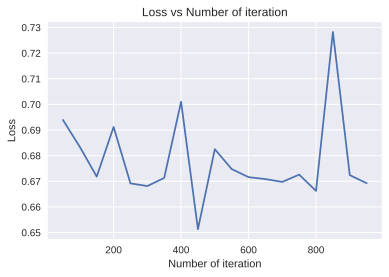

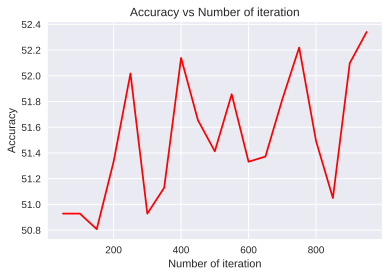

In [ ]:
draw_visualization(it, losses, acs)

**Prediction**

In [ ]:
_ = load_checkpoint('./lstm_w2v_best_checkpoint', lstm_model_w2v, optimizer)

Loading checkpoint './lstm_w2v_best_checkpoint'
Loaded checkpoint './lstm_w2v_best_checkpoint' from iteration 950


In [ ]:
test_vec, vlen, test_lbls = next(iter(test_loader))

with torch.no_grad(): 
  test_outputs = lstm_model_w2v(test_vec)

In [ ]:
predicted = torch.max(test_outputs.data,1)[1]  # [1]
predicted

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

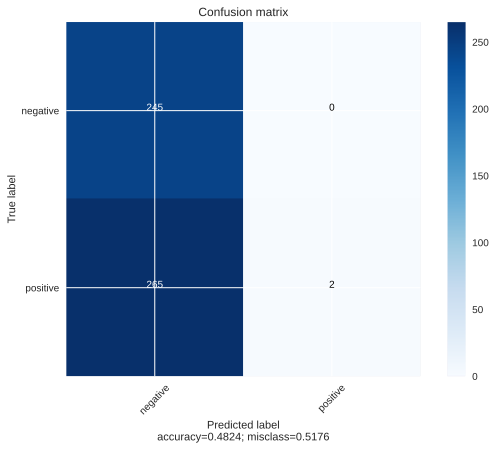

Accuracy: 0.48242 
Balanced accuracy: 0.50375 
Multiclass f1-score: 
    micro: 0.48242 
    macro: 0.33194 
    weighted: 0.31831


Classification report:

              precision    recall  f1-score   support

           0    0.48039   1.00000   0.64901       245
           1    1.00000   0.00749   0.01487       267

    accuracy                        0.48242       512
   macro avg    0.74020   0.50375   0.33194       512
weighted avg    0.75136   0.48242   0.31831       512



In [ ]:
calc_metrics(test_lbls, predicted)

**Conclusion** 

* This model doesn't cope with this task. I think that this pre-trained embedding finds extremely few words from our dataset, that is why the scores are so low. I also think that a longer training session is needed for such a large dataset + GPU connection (it could not be obtained from google colab ;((( )

* Simple **accuracy** gives an bad result-0.48, but you should not believe this estimate 100 percent, so it's worth looking at a balanced accuracy.

* **Balanced Accuracy** tries to account for the imbalance in the classes and outputs a value of - 0.5, which is still bad.

* My classifier identifies one class (a little bit higher then random model) -  0.64 and the 2nd one - bad (0.01 - doesn't identify at all), which is very bad. This fact is also confirmed by the **f1-score** metric. 



# **BERT Model**

In [ ]:
!pip install transformers==3

In [ ]:
import transformers
from sklearn.metrics import classification_report
from transformers import BertTokenizerFast
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from typing import Tuple, List
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup, BertPreTrainedModel, BertConfig

**Split and load data**

In [ ]:
trainData, valData = train_test_split(clean_data,
                                      test_size=0.2,
                                      random_state=42,
                                      stratify=clean_data['sentiment'])

trainData,testData = train_test_split(trainData,
                                       test_size=0.2,
                                       random_state=42,
                                       stratify=trainData['sentiment'])

In [ ]:
class MovieDatasetLoader(Dataset):
    
    def __init__(self, tokenizer: BertTokenizer, dataframe: pd.DataFrame, lazy: bool = False):
        self.tokenizer = tokenizer
        self.pad_idx = tokenizer.pad_token_id
        self.lazy = lazy
        if not self.lazy:
            self.X = []
            self.Y = []
            for i, (row) in tqdm(dataframe.iterrows()):
                x, y = self.row_to_tensor(self.tokenizer, row)
                self.X.append(x)
                self.Y.append(y)
        else:
            self.df = dataframe        
    
    @staticmethod
    def row_to_tensor(tokenizer: BertTokenizer, row: pd.Series) -> Tuple[torch.LongTensor, torch.LongTensor]:
        tokens = tokenizer.encode(row["review"], add_special_tokens=True)
        if len(tokens) > 120:
            tokens = tokens[:119] + [tokens[-1]]
        x = torch.LongTensor(tokens)
        y = torch.FloatTensor(row[['sentiment']])
        return x, y
        
    
    def __len__(self):
        if self.lazy:
            return len(self.df)
        else:
            return len(self.X)

    def __getitem__(self, index: int) -> Tuple[torch.LongTensor, torch.LongTensor]:
        if not self.lazy:
            return self.X[index], self.Y[index]
        else:
            return self.row_to_tensor(self.tokenizer, self.df.iloc[index])

In [ ]:
bert_model_name = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

In [ ]:
train_dataset = MovieDatasetLoader(tokenizer, trainData, lazy=True)
val_dataset = MovieDatasetLoader(tokenizer, valData, lazy=True)

In [ ]:
BATCH_SIZE = 16
train_sampler = RandomSampler(train_dataset)
val_sampler = RandomSampler(val_dataset)


def collate(batch):
    vector = [item[0] for item in batch]

    vector = pad_sequence(vector, batch_first=True,  padding_value=0)

    target = torch.LongTensor([item[1] for item in batch])

    return vector,target

train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, collate_fn=collate)
val_iterator = DataLoader(val_dataset, batch_size=BATCH_SIZE, sampler=val_sampler, collate_fn=collate)

In [ ]:
for vec, lbl in train_iterator:
  print(vec.shape)
  break

torch.Size([16, 120])


**Model**

In [ ]:
class BertClassifier(nn.Module):
    
    def __init__(self, bert: BertModel, num_classes: int):
        super().__init__()
        self.bert = bert
        self.classifier = nn.Linear(bert.config.hidden_size, num_classes)
        self.sm = nn.Softmax(dim=-1)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None,  
            labels=None):
      
        outputs = self.bert(input_ids,
                               attention_mask=attention_mask,
                               token_type_ids=token_type_ids,
                               position_ids=position_ids,
                               head_mask=head_mask)
        
        outputs = outputs[1].detach()
        cls_output = outputs # batch, hidden
        cls_output = self.classifier(cls_output) # batch, 1
        cls_output = self.sm(cls_output)

        return cls_output

In [ ]:
def train(model, optimizer, criterion, 
          train_loader, val_loader, 
          epochs=100, iter_per_validation=50,
          early_stopping=False,
          checkpoint_path="./best_checkpoint",
          save_by="accuracy"):
  iteration = 0
  loss_list = []
  iteration_list = []
  accuracy_list = []
  best_score = None

  for epoch in range(epochs):
      print(f"Epoch {epoch}")

      for vec, labels in train_loader:
          model.train()
          # Clear gradients
          optimizer.zero_grad()
        
          # Forward propagation
          outputs = model(vec)
      
          # Calculate softmax and ross entropy loss
          loss = criterion(outputs, labels)
          
          # Calculating gradients
          loss.backward()
          
          # Update parameters
          optimizer.step()
          
          iteration += 1
          
          if iteration % iter_per_validation == 0:
              model.eval()
              with torch.no_grad():
                # Calculate Accuracy         
                correct = 0
                total = 0
                # Iterate through test dataset

                for vec, labels in val_loader:

                    # Forward propagation
                    outputs = model(vec)

                    # Get predictions from the maximum value
                    predicted = torch.max(outputs.data, 1)[1]
                    
                    # Total number of labels
                    total += len(labels)
                    
                    correct += (predicted == labels).sum()
                
                accuracy = 100 * correct / float(total)
            
                # store loss and iteration
                loss_list.append(loss.data)
                iteration_list.append(iteration)
                accuracy_list.append(accuracy)
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(iteration, loss.data, accuracy))

                # save if we have best model state
                ref_score = accuracy if save_by == "accuracy" else loss.data
                compare = (lambda x, y: x > y) if save_by == "accuracy" else (lambda x, y: x < y)
                if best_score is None or compare(ref_score, best_score):
                    best_score = ref_score
                    save_checkpoint(model, optimizer, 
                                    optimizer.state_dict()['param_groups'][0]['lr'], 
                                    iteration, checkpoint_path)
                    
                 # Early stopping if the current valid_loss is greater than the last three valid losses
                if  early_stopping == True:
                    if len(accuracy_list) > 3 and all(accuracy >= acc for acc in accuracy_list[-4:]):
                        print('Stopping early')
                        break

  return iteration_list, loss_list, accuracy_list

In [ ]:
bert_model = BertClassifier(BertModel.from_pretrained(bert_model_name), 2)

In [ ]:
learning_rate = 0.001 # 
batch_size = 16
output_size = 2

EPOCH = 2

In [ ]:
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(bert_model.parameters(),lr=learning_rate)

no_decay = ['bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
{'params': [p for n, p in bert_model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
{'params': [p for n, p in bert_model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]


optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, eps=1e-8)

In [ ]:
it, losses, acs = train(bert_model,
                        optimizer,
                        loss_fn,
                        train_iterator, 
                        val_iterator,
                        EPOCH, 
                        # early_stopping=True,
                        checkpoint_path='./bert_best_checkpoint')

Epoch 0


Token indices sequence length is longer than the specified maximum sequence length for this model (608 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (699 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (538 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (648 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (627 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Iteration: 50  Loss: 0.6826831698417664  Accuracy: 50.17144012451172 %
Saving model and optimizer state at iteration 50 to ./bert_best_checkpoint


Token indices sequence length is longer than the specified maximum sequence length for this model (543 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (519 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (721 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Iteration: 100  Loss: 0.6924991011619568  Accuracy: 50.070594787597656 %


Token indices sequence length is longer than the specified maximum sequence length for this model (577 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (543 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (607 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (563 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (699 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

### **Unfortunately, for the BERT model, I again failed to get a GPU, so I began to train it on the CPU, after 5 hours - only 100 iterations passed and the colab turned off, I think that for such a large model it does not make sense to conduct training on the CPU.**

![picture](https://drive.google.com/uc?export=view&id=1BgIrSSRXfEkBmV19_aIF1fAGFYD3ClTj)

**visualization**

In [ ]:
draw_visualization(it, losses, acs)

**Prediction**

In [ ]:
_ = load_checkpoint('./bert_best_checkpoint', bert_model, optimizer)

In [ ]:
test_vec, vlen, test_lbls = next(iter(test_loader))
with torch.no_grad(): 
  test_outputs = bert_model(test_vec)

predicted = torch.max(test_outputs.data,1)[1]  # [1]
predicted

In [ ]:
calc_metrics(test_lbls, predicted)

# **General conclusion**

* Speaking about the pre-processing of the text, the main stages of cleaning were summed up (removing punctuation, stop words, etc.). It would also be possible to correct spelling errors in the text, but the power of my computer was not enough to process the entire text in an acceptable time.

* Comparing tf-idf embedding and pre-trained embeddings, such as Word2Vec & Glove, I want to say that Tf-Idf coped much better with the presented classification task.

* Models with pre-trained embeddings showed strikingly poor results (as a random model), however, I think it's worth training these models much longer, and since the GPU could not be obtained, I had to do everything possible on the CPU.

* A simple linear model with Tf Idf embedding showed a good result on only 36 epochs.

      Accuracy: 0.84705 
      Balanced accuracy: 0.84696 
      Multiclass f1-score: 
          micro: 0.84705 
          macro: 0.84697 
          weighted: 0.84705


    Classification report:

              precision    recall  f1-score   support

           0    0.84450   0.84241   0.84345      1212
           1    0.84949   0.85150   0.85049      1266


* Comparing with ML models, I can say that the results of the metrics turned out to be a little bit smaller in DL.  
 **Example:** ML SVM model --> Scores: 
 
    *f1-score* 
              0 class = 0.904  
              1 class = 0.906

* Unfortunately, for the BERT model, I again failed to get a GPU, so I began to train it on the CPU, after 5 hours - only 100 iterations (in 1st epoch) passed and the colab turned off, I think that for such a large model it does not make sense to conduct training on the CPU.

* I mainly focused on the "f1-score" metric, since it is something in between recall and precision. It was more convenient to focus on its values.  Also, accuracy and balanced accuracy show the same results (similar and high).
